# EDA

## 讀取,轉換字串成可以訓練的資料

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline
data_path = '../data'

random_seed = 2000

In [2]:
data_list=['raw_data.csv','FE_data1.csv','FE_data2.csv','FE_data3.csv']#,'FE_data2.csv','FE_data4.csv'

data=[]
for d in data_list:
    x = pd.read_csv('../data/preprocess/{}'.format(d))
    print('\n',d,x.shape)
    x_null = x.isnull().sum()
    print("Null columns:\n",x_null[x_null>0])
    
    if (d=='FE_data1.csv') or (d=='FE_data2.csv'):
        x.fillna(value=-1,inplace=True)
        
    data.append(x)

all_data = pd.concat(data,axis=1)

all_data_numsum = all_data.isnull().sum()
print('ALL data null:')
print(all_data_numsum[all_data_numsum>0])


 raw_data.csv (1943452, 23)
Null columns:
 fraud_ind    421665
dtype: int64

 FE_data1.csv (1943452, 50)
Null columns:
 cano_conam_skew      92612
cano_conam_kurt     155720
cano_conam_var       38678
bacno_locdt_skew     58303
bacno_locdt_kurt    101191
cano_locdt_skew      92612
cano_locdt_kurt     155720
dtype: int64

 FE_data2.csv (1943452, 4)
Null columns:
 Series([], dtype: int64)

 FE_data3.csv (1943452, 9)
Null columns:
 Series([], dtype: int64)
ALL data null:
fraud_ind    421665
dtype: int64


In [3]:
bool_cols = all_data.columns[all_data.dtypes==bool].values
for b in bool_cols:
    all_data[b] = all_data[b].map({True:1,False:0}) 

## EDA(觀察資料分佈, 找特徵工程的Idea）

#### 方法（四種）:
1. 比較train, validation data, test data各個feature(不包括fraud_ind)的分佈，看各個feature是否會隨時間不同而改變
    * 見 function compare_distribution
    * 檢查差異,目測結果: txkey有一點差異，其他幾乎一樣
    

2. 比較train, validation data各個feature相對於fraud_ind的關係，看他們與fraud_ind的關係是否會隨時間改變，如果會就不適合做training feature
    * 見 function analze_distribution
    * 檢查差異，目測結果:
        * 明顯差異,應該去除,或應該抽取更高層的穩定特徵(TODO): csmcu,mcc,loctm_hr2
        * 無法判讀:應該找出來並想辦法去除或找更高層特徵(TODO): 蠻多特徵都看不出來有沒有差,因為類別太多＝＝


3. 比較normal, fraud data的各個feature分佈差異，找有問題的feature!
    * 結果:


4. 但這樣無法看出單一用戶在normal和fraud的關係，所以要另外印出檢查，看有fraud data的用戶，該資料特點在哪
    * 根據時間順序,以每個bacno來看fraud情況(最重要,適合找data leakage!!!!)
    

## 觀測 train, validation, test的distribution
* 跟fraud_ind相關的，檢查train和validation就好（假設test data跟validation類似）
* 每筆feature的distribution，檢查train,validation和test


In [4]:
def analze_distribution(data, target_col, feature, data_test):
#     if data[feature].nunique()!=data_test[feature].nunique():
#         print('data nunique not the same')
    print(feature)
    plt.clf()
    mean_data = data.groupby(feature)[target_col].mean()
    mean_data_test = data_test.groupby(feature)[target_col].mean()
    distribution_data = data[feature].value_counts(dropna=False)
    distribution_data_test = data_test[feature].value_counts(dropna=False)
    
    fig, axs = plt.subplots(2,2,figsize=(10,5))
    axs[0,0].plot(mean_data.index, mean_data.values, marker='o')
    axs[0,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[0,0].set_ylabel('mean of {}'.format(target_col))
    axs[0,0].set_xlabel(feature)
    
    
    bins = data[feature].nunique() if data[feature].nunique()<100 else 100
    data[feature].hist(bins=bins,ax=axs[0,1])

#     axs[0,1].bar(distribution_data.index, distribution_data.values, alpha=0.5)
    axs[0,1].set_title('distribution of {}'.format(feature))
    axs[0,1].set_ylabel('count of {}'.format(feature))
    axs[0,1].set_xlabel(feature)
    
    # Add text in figure coordinates
    plt.figtext(0.5, 1,   'Train data plot', ha='center', va='center', fontsize=15)
    plt.figtext(0.5, 0.5, 'Test data plot', ha='center', va='center', fontsize=15)
    axs[1,0].plot(mean_data_test.index, mean_data_test.values, marker='o')
    axs[1,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[1,0].set_ylabel('mean of {}'.format(target_col))
    axs[1,0].set_xlabel(feature)
    
    bins = data_test[feature].nunique() if data_test[feature].nunique()<100 else 100
    data_test[feature].hist(bins=bins,ax=axs[1,1])
#     axs[1,1].bar(distribution_data_test.index, distribution_data_test.values, alpha=0.5)
    distribution_data_test.hist
    axs[1,1].set_title('distribution of {}'.format(feature))
    axs[1,1].set_ylabel('count of {}'.format(feature))
    axs[1,1].set_xlabel(feature)
    plt.tight_layout(pad=3)
    plt.show()

acqic


<Figure size 432x288 with 0 Axes>

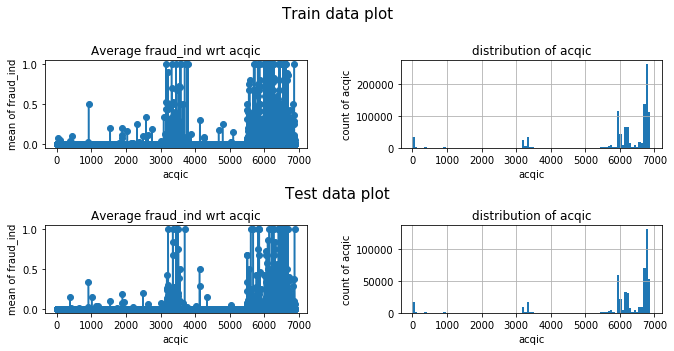

bacno


<Figure size 432x288 with 0 Axes>

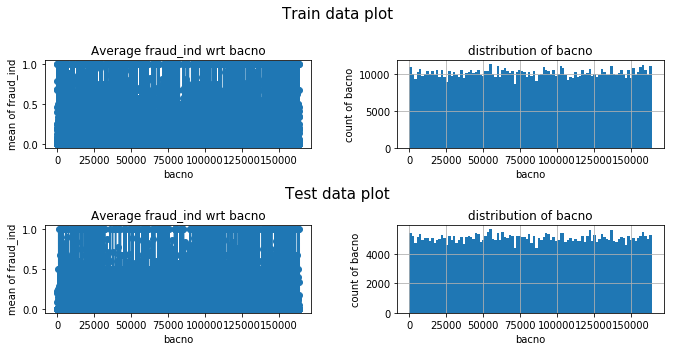

cano


<Figure size 432x288 with 0 Axes>

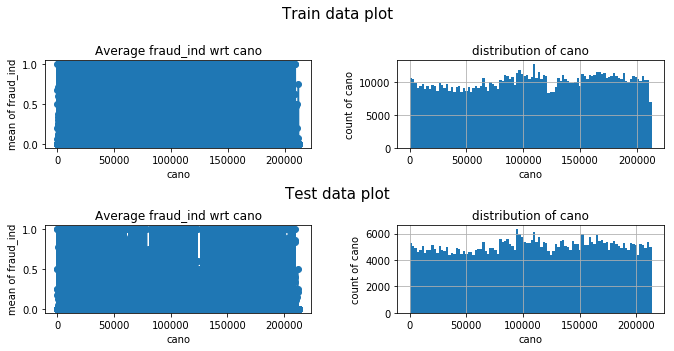

conam


<Figure size 432x288 with 0 Axes>

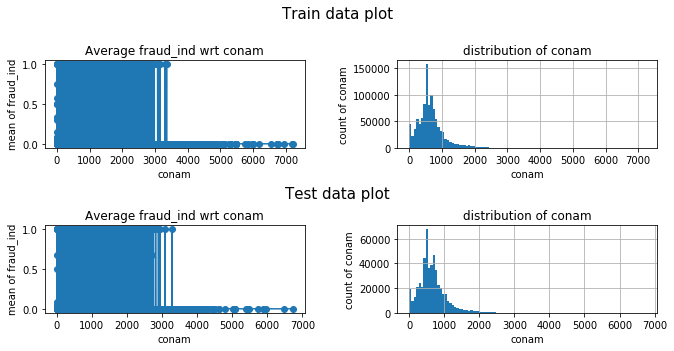

contp


<Figure size 432x288 with 0 Axes>

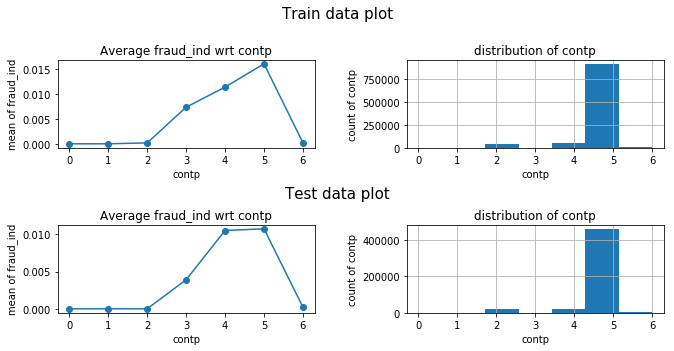

csmcu


<Figure size 432x288 with 0 Axes>

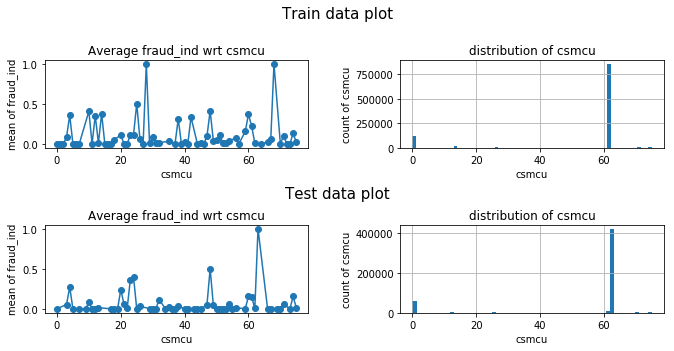

ecfg


<Figure size 432x288 with 0 Axes>

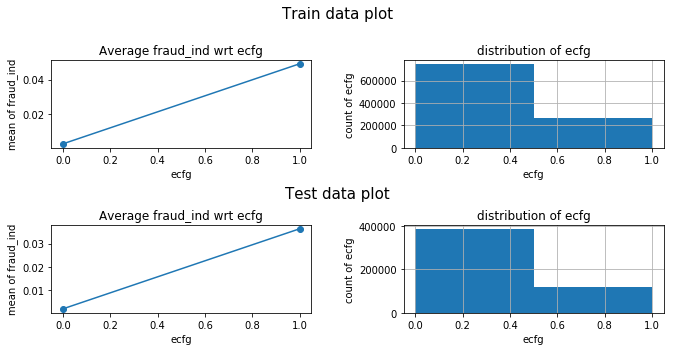

etymd


<Figure size 432x288 with 0 Axes>

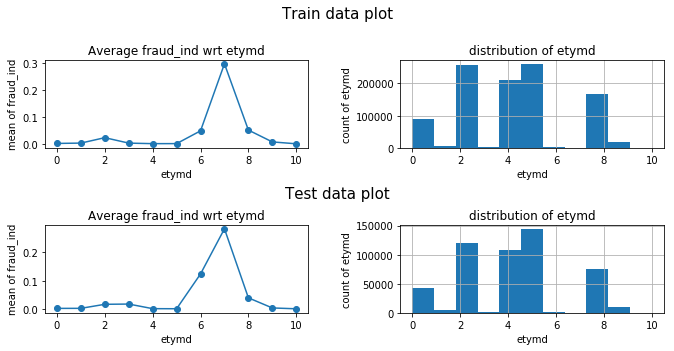

flbmk


<Figure size 432x288 with 0 Axes>

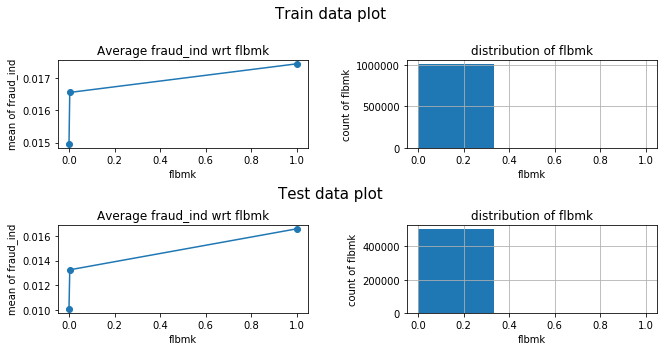

flg_3dsmk


<Figure size 432x288 with 0 Axes>

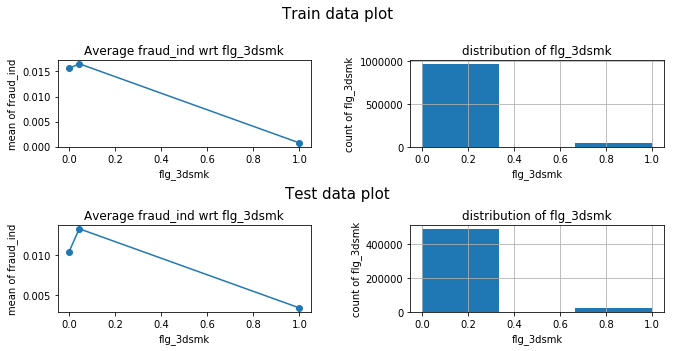

fraud_ind


<Figure size 432x288 with 0 Axes>

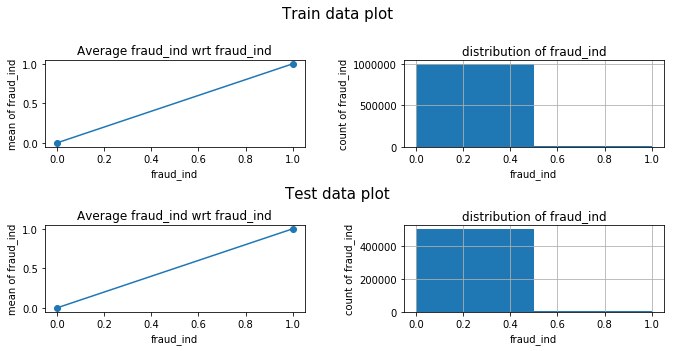

hcefg


<Figure size 432x288 with 0 Axes>

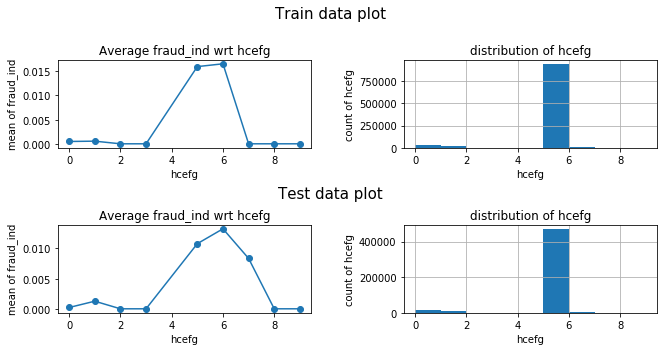

insfg


<Figure size 432x288 with 0 Axes>

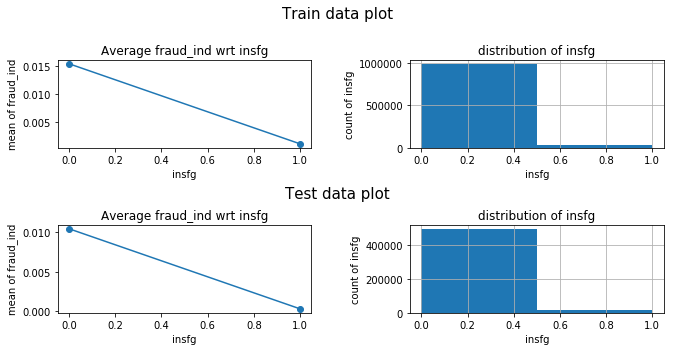

iterm


<Figure size 432x288 with 0 Axes>

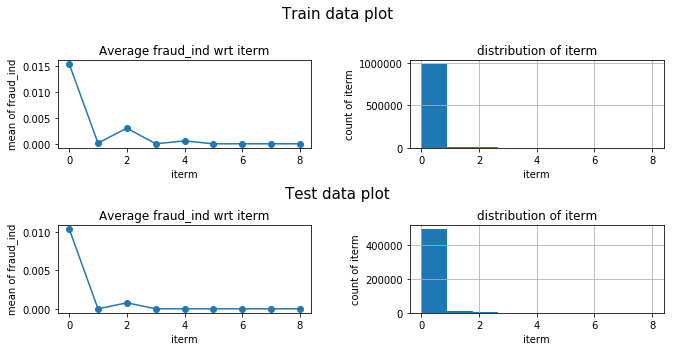

locdt


<Figure size 432x288 with 0 Axes>

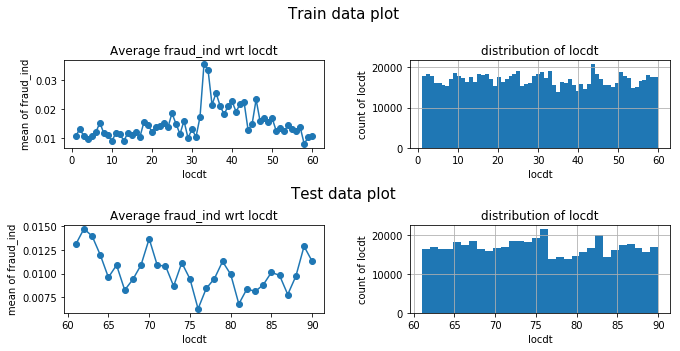

loctm


<Figure size 432x288 with 0 Axes>

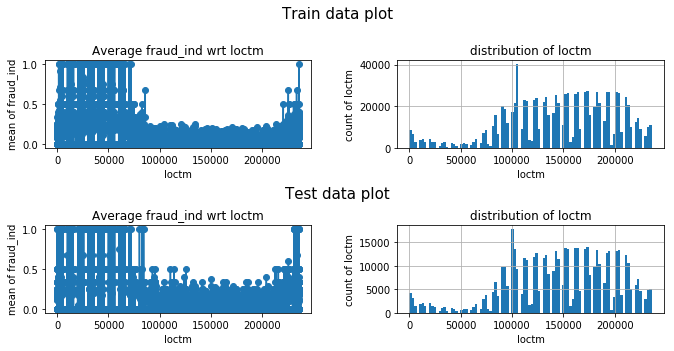

mcc


<Figure size 432x288 with 0 Axes>

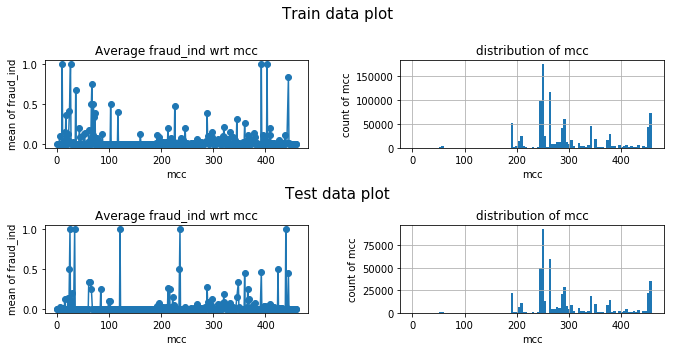

mchno


<Figure size 432x288 with 0 Axes>

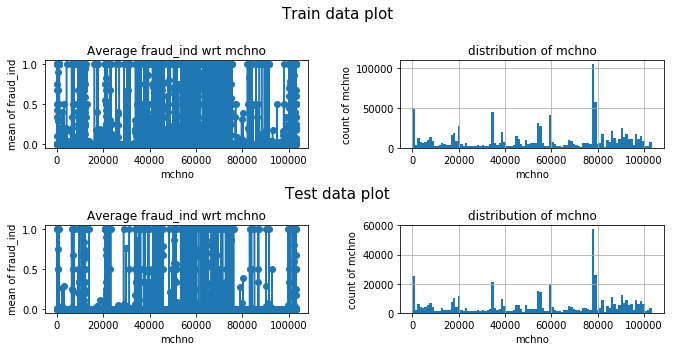

ovrlt


<Figure size 432x288 with 0 Axes>

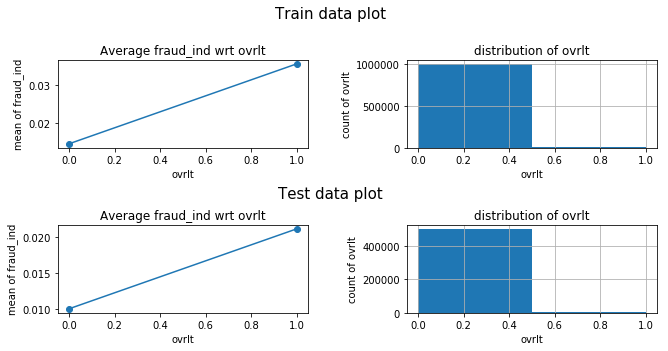

scity


<Figure size 432x288 with 0 Axes>

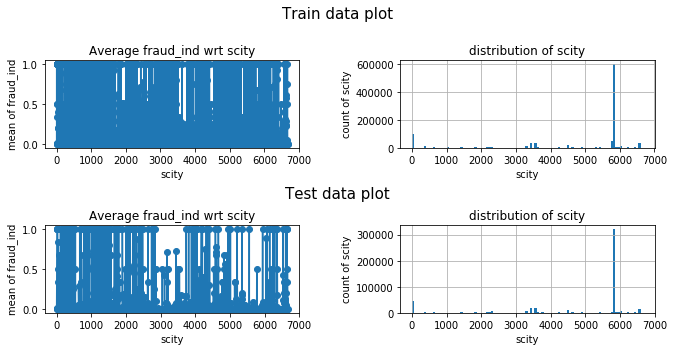

stocn


<Figure size 432x288 with 0 Axes>

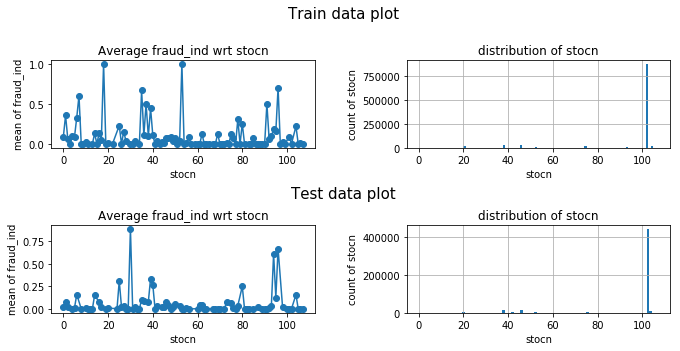

stscd


<Figure size 432x288 with 0 Axes>

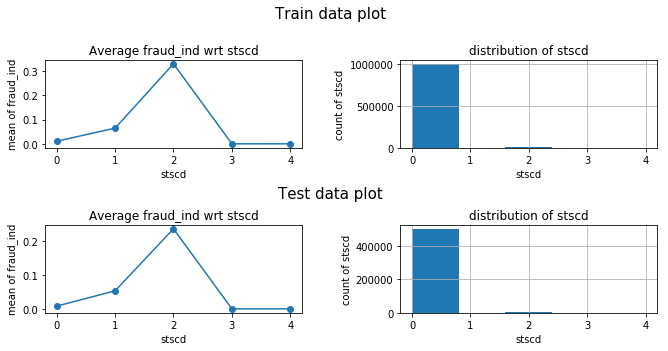

txkey


<Figure size 432x288 with 0 Axes>

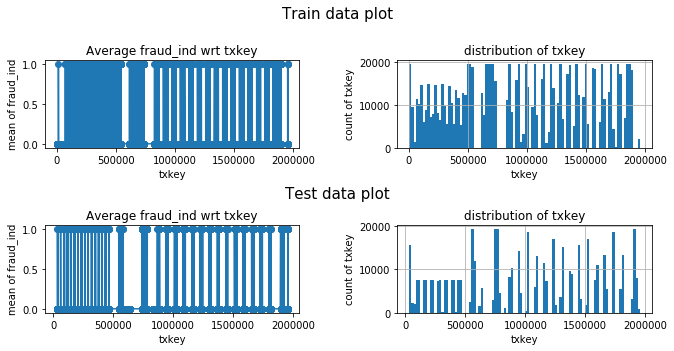

bacno_cano_nunique


<Figure size 432x288 with 0 Axes>

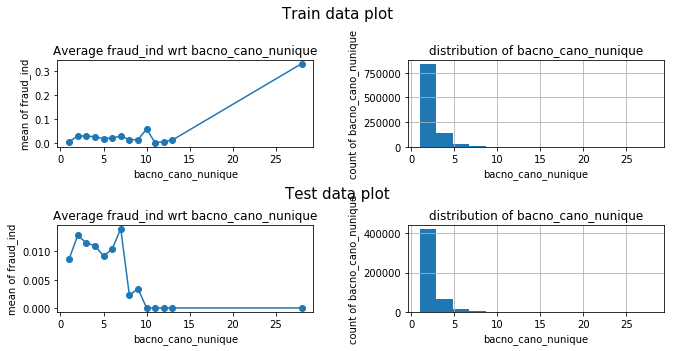

bacno_txkey_nunique


<Figure size 432x288 with 0 Axes>

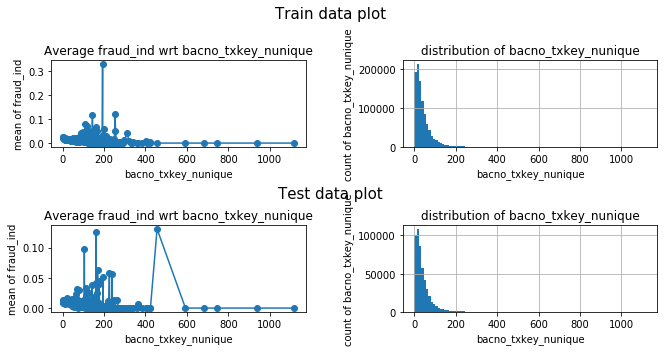

conam_log


<Figure size 432x288 with 0 Axes>

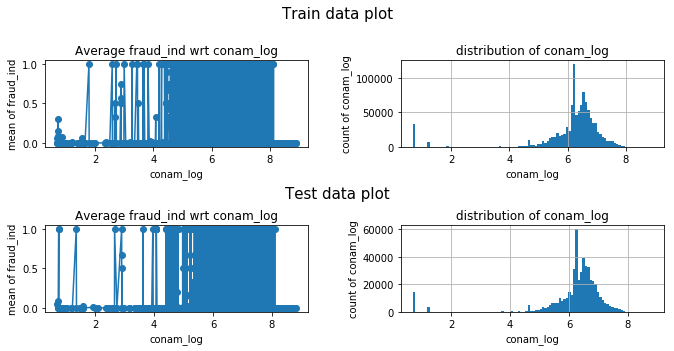

bacno_mean_conam


<Figure size 432x288 with 0 Axes>

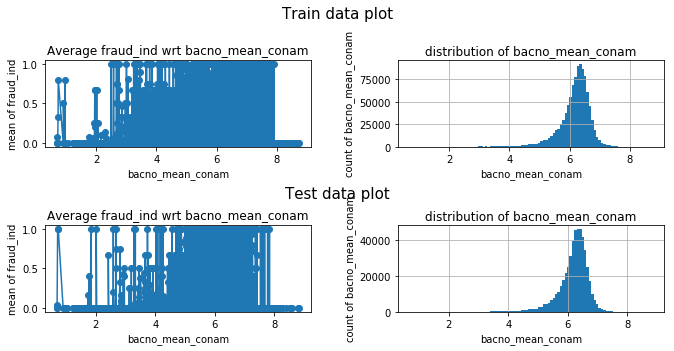

bacno_scale_conam


<Figure size 432x288 with 0 Axes>

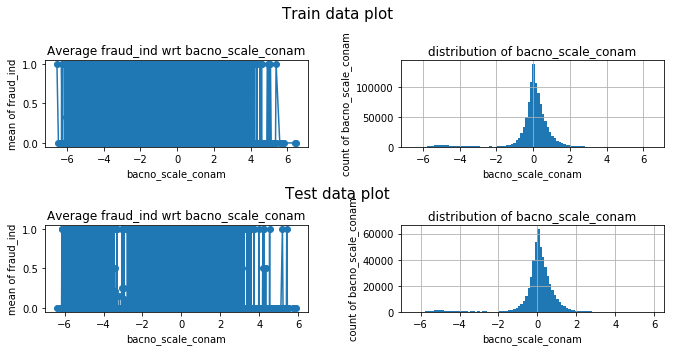

cano_mean_conam


<Figure size 432x288 with 0 Axes>

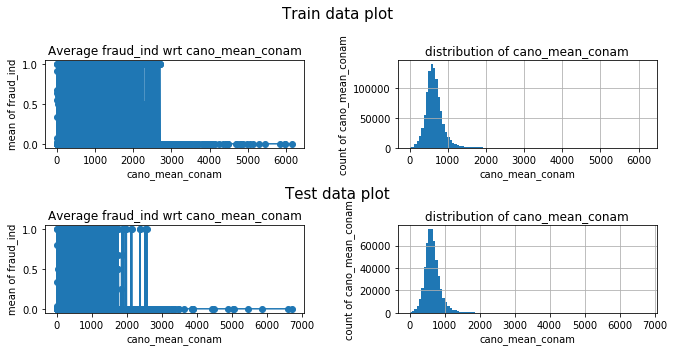

cano_scale_conam


<Figure size 432x288 with 0 Axes>

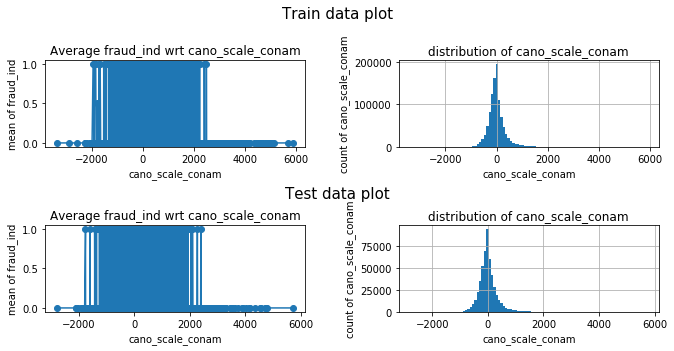

cano_conam_skew


<Figure size 432x288 with 0 Axes>

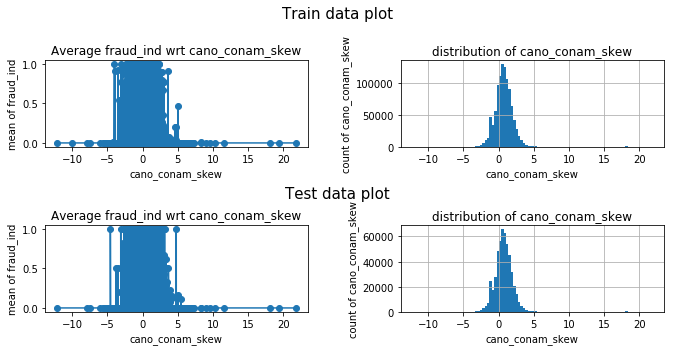

cano_conam_kurt


<Figure size 432x288 with 0 Axes>

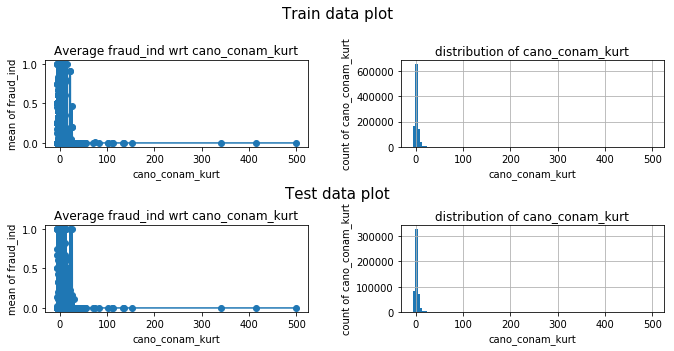

cano_conam_mean


<Figure size 432x288 with 0 Axes>

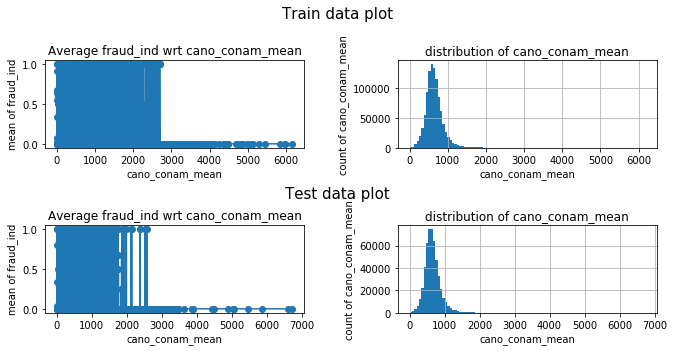

cano_conam_var


<Figure size 432x288 with 0 Axes>

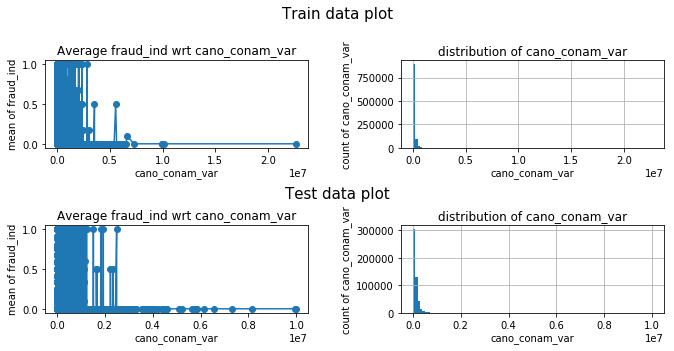

bacno_max_conam


<Figure size 432x288 with 0 Axes>

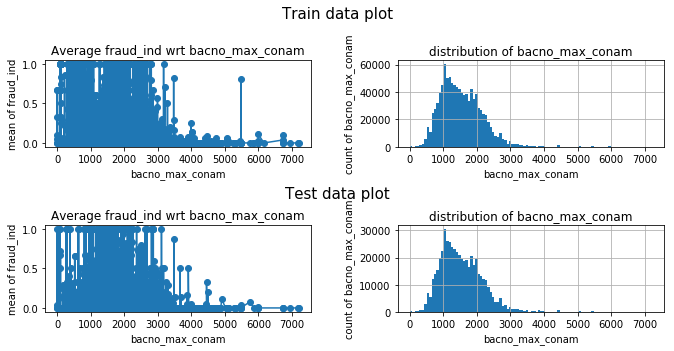

bacno_ismax_conam


<Figure size 432x288 with 0 Axes>

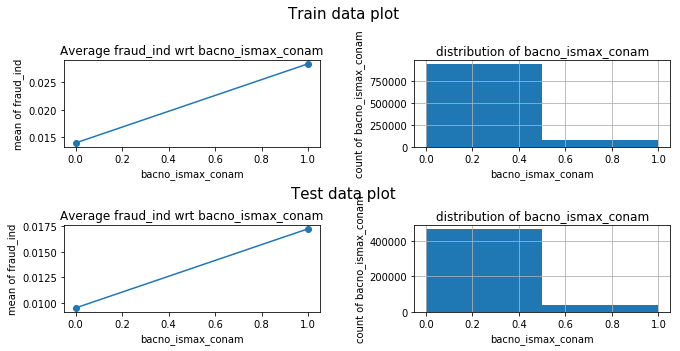

bacno_min_conam


<Figure size 432x288 with 0 Axes>

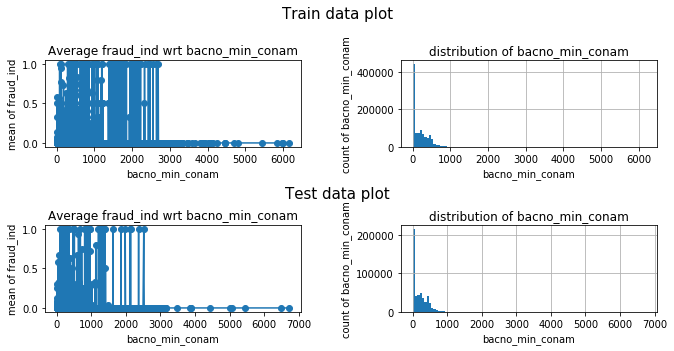

bacno_ismin_conam


<Figure size 432x288 with 0 Axes>

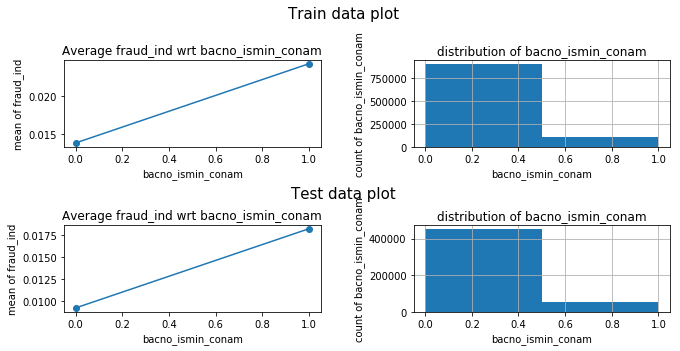

bacno_ratio_ecfg


<Figure size 432x288 with 0 Axes>

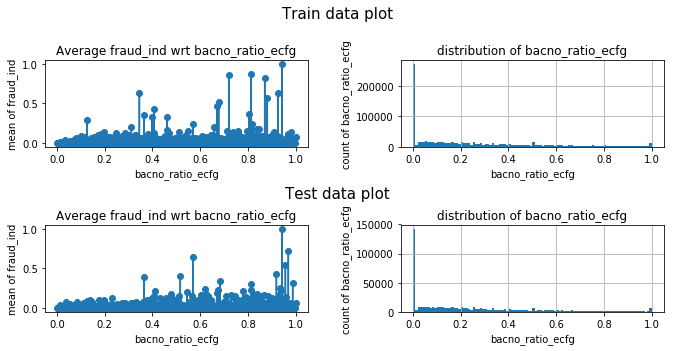

cano_ratio_ecfg


<Figure size 432x288 with 0 Axes>

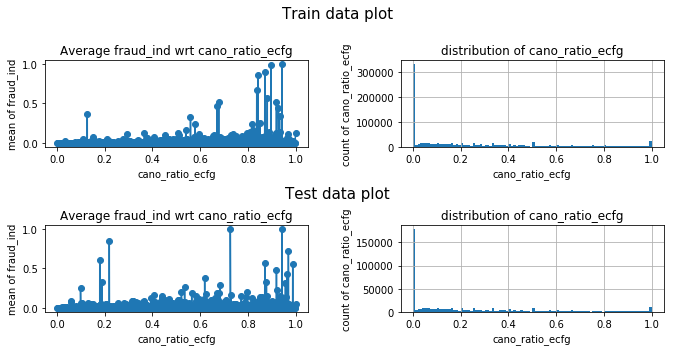

locdt_week


<Figure size 432x288 with 0 Axes>

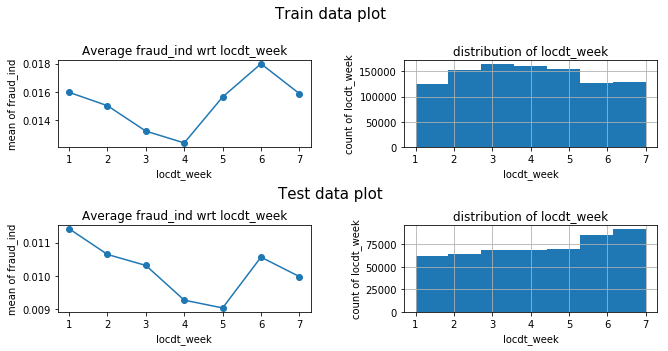

loctm_hr


<Figure size 432x288 with 0 Axes>

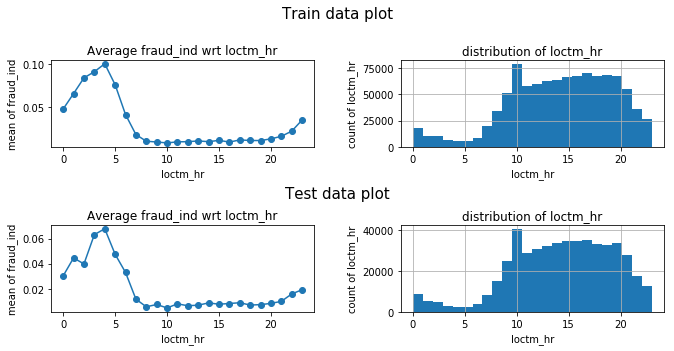

bacno_locdt_skew


<Figure size 432x288 with 0 Axes>

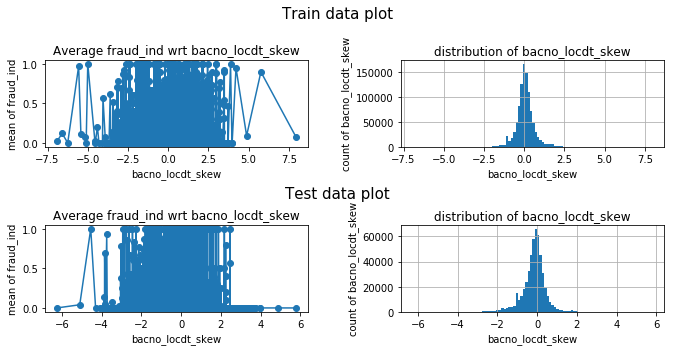

bacno_locdt_kurt


<Figure size 432x288 with 0 Axes>

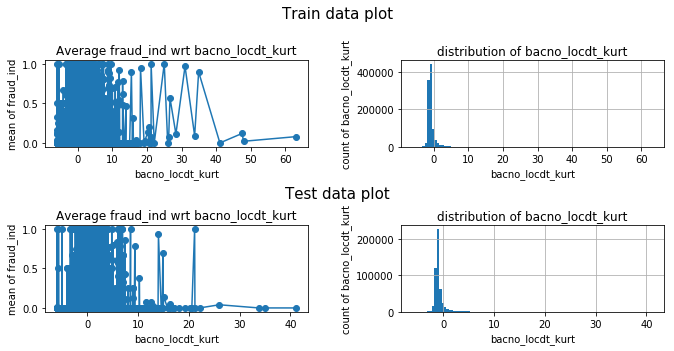

cano_locdt_skew


<Figure size 432x288 with 0 Axes>

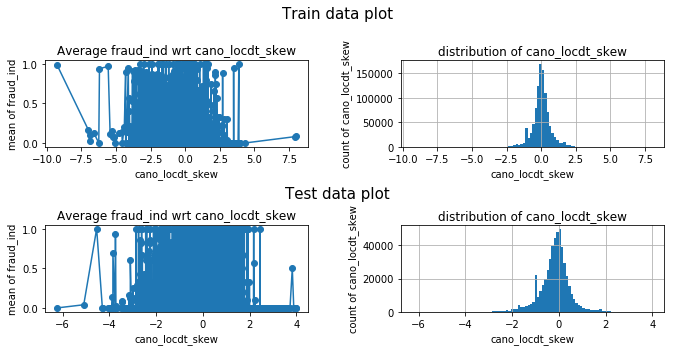

cano_locdt_kurt


<Figure size 432x288 with 0 Axes>

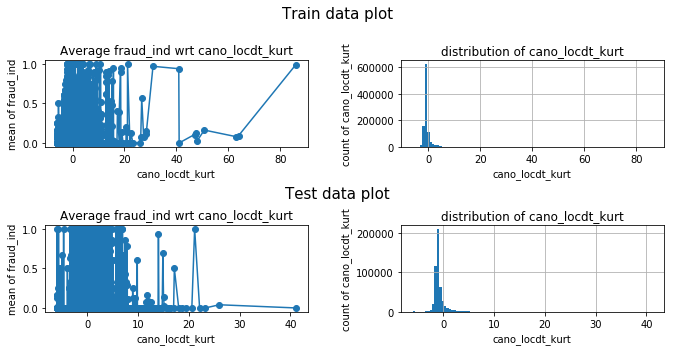

bacno_stocn_mode


<Figure size 432x288 with 0 Axes>

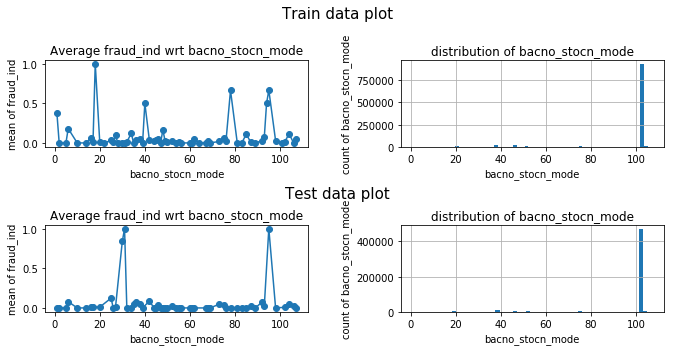

bacno_scity_mode


<Figure size 432x288 with 0 Axes>

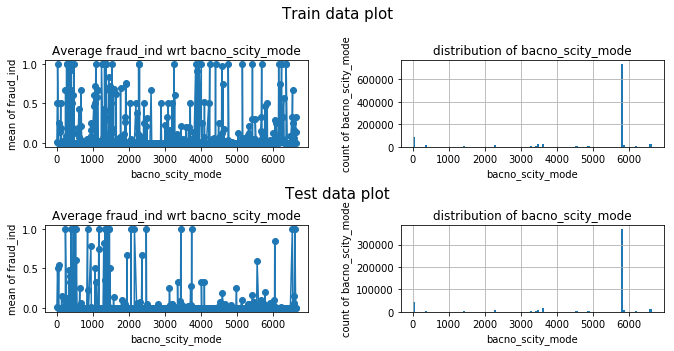

bacno_csmcu_mode


<Figure size 432x288 with 0 Axes>

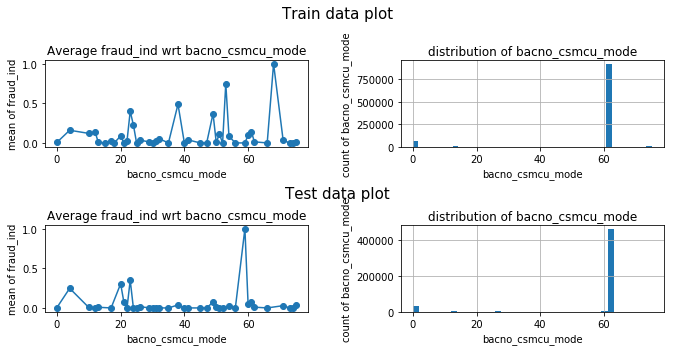

bacno_stocn_ismode


<Figure size 432x288 with 0 Axes>

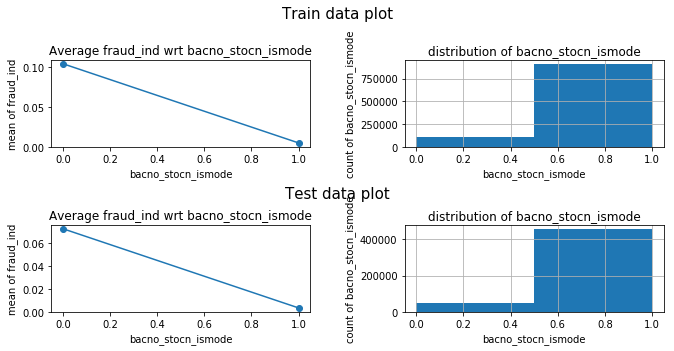

bacno_scity_ismode


<Figure size 432x288 with 0 Axes>

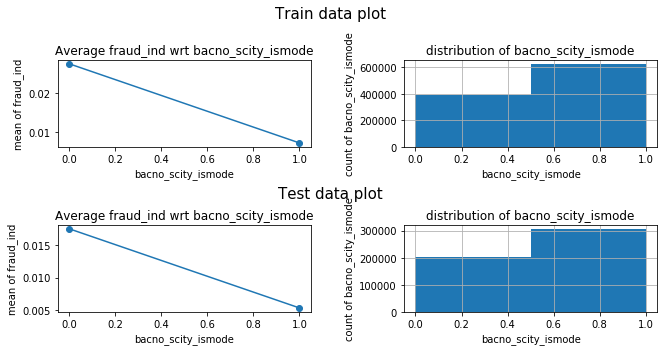

bacno_csmcu_ismode


<Figure size 432x288 with 0 Axes>

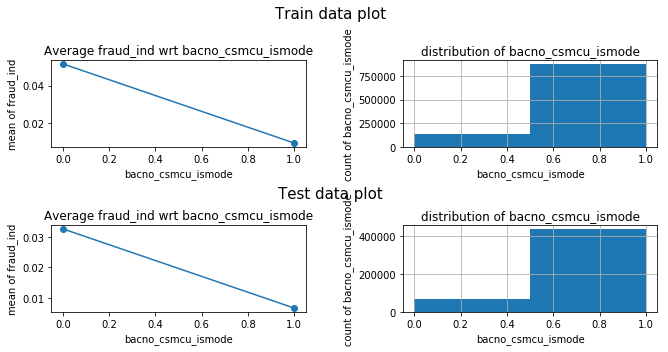

cano_stocn_mode


<Figure size 432x288 with 0 Axes>

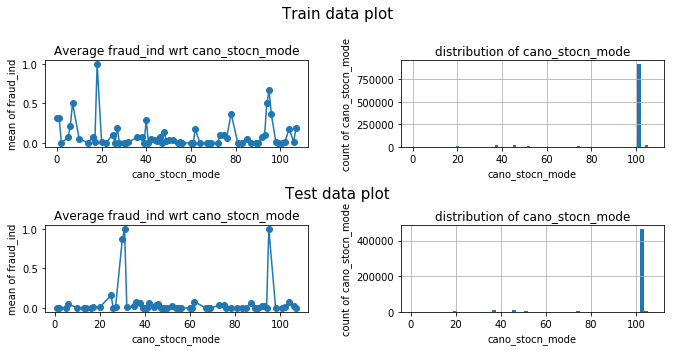

cano_scity_mode


<Figure size 432x288 with 0 Axes>

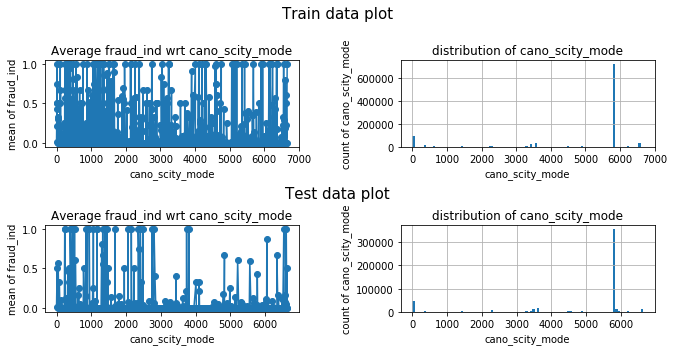

cano_csmcu_mode


<Figure size 432x288 with 0 Axes>

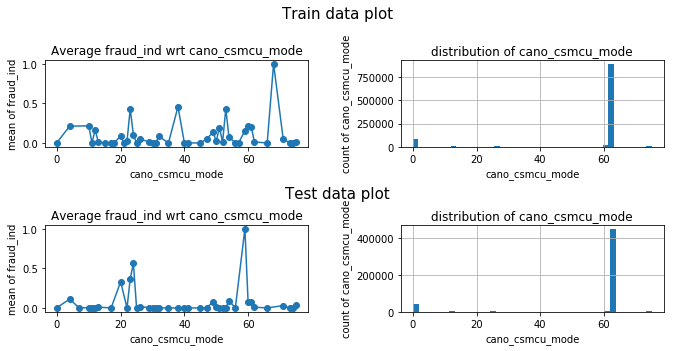

cano_stocn_ismode


<Figure size 432x288 with 0 Axes>

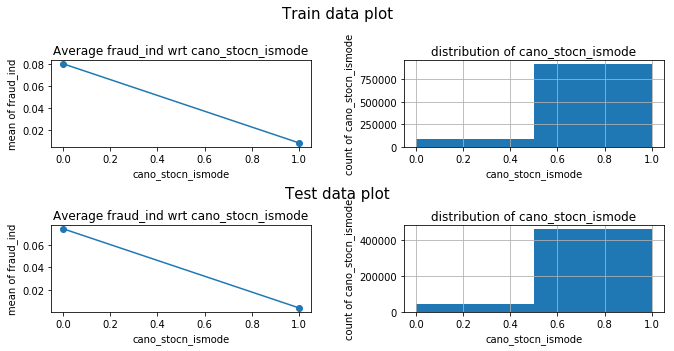

cano_scity_ismode


<Figure size 432x288 with 0 Axes>

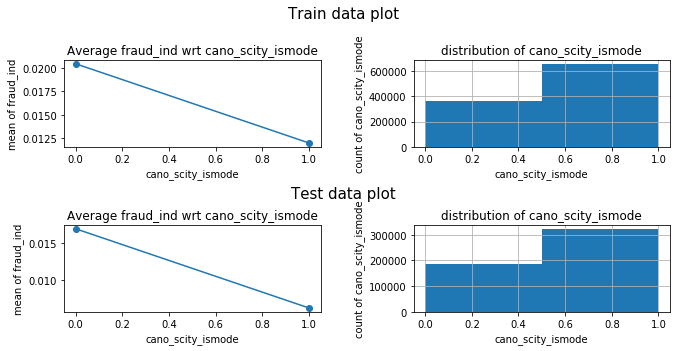

cano_csmcu_ismode


<Figure size 432x288 with 0 Axes>

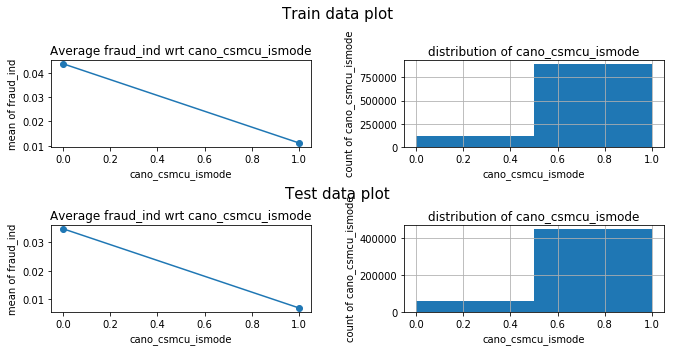

mchno_fraud_mean


<Figure size 432x288 with 0 Axes>

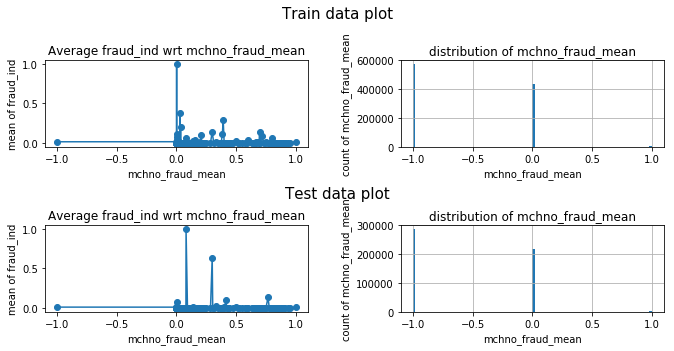

mcc_fraud_mean


<Figure size 432x288 with 0 Axes>

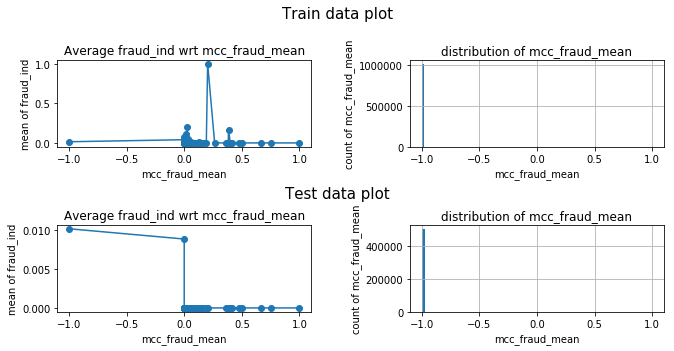

acqic_fraud_mean


<Figure size 432x288 with 0 Axes>

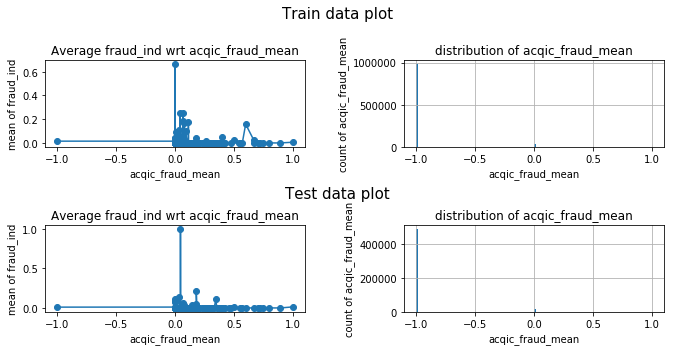

mchno_bacno_nunique


<Figure size 432x288 with 0 Axes>

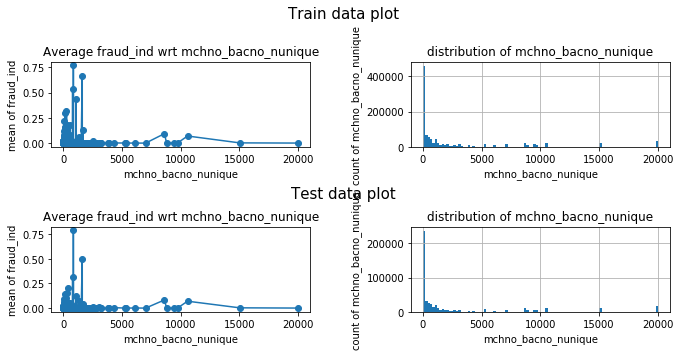

acqic_bacno_nunique


<Figure size 432x288 with 0 Axes>

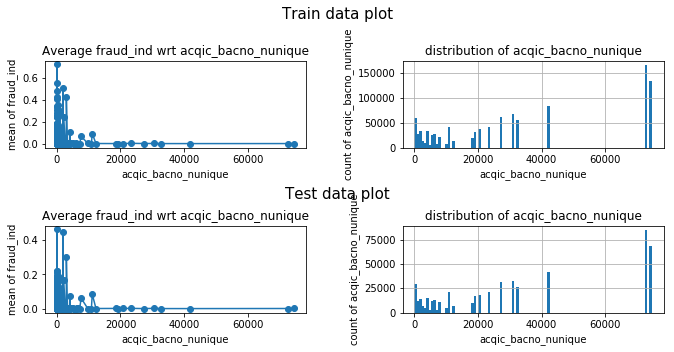

mcc_bacno_nunique


<Figure size 432x288 with 0 Axes>

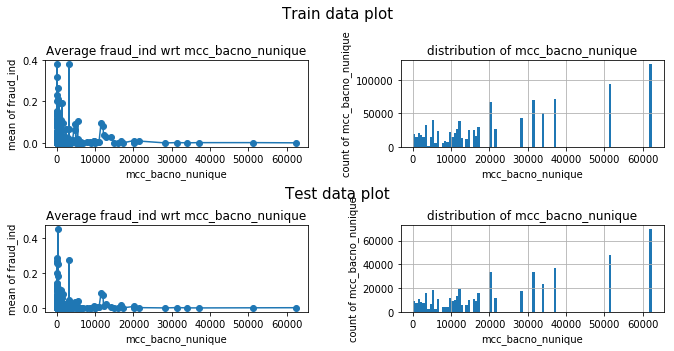

stocn_bacno_nunique


<Figure size 432x288 with 0 Axes>

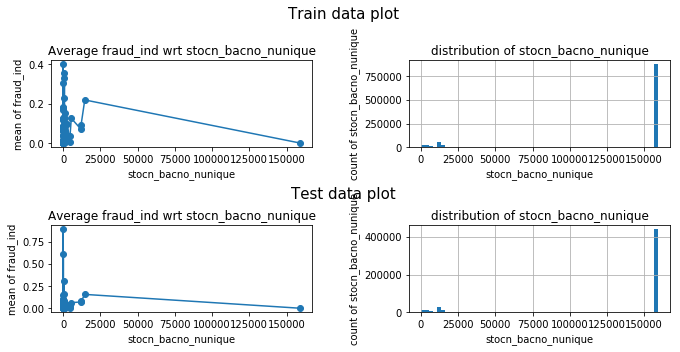

scity_bacno_nunique


<Figure size 432x288 with 0 Axes>

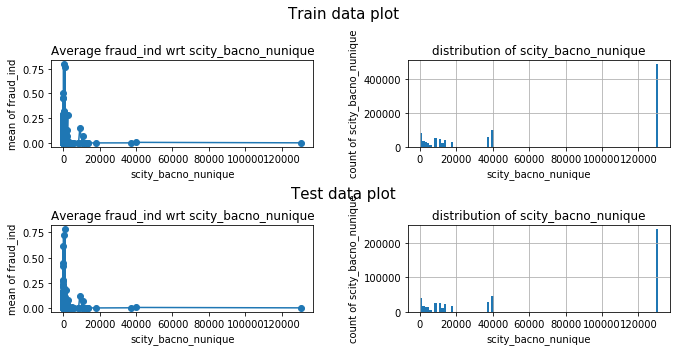

csmcu_bacno_nunique


<Figure size 432x288 with 0 Axes>

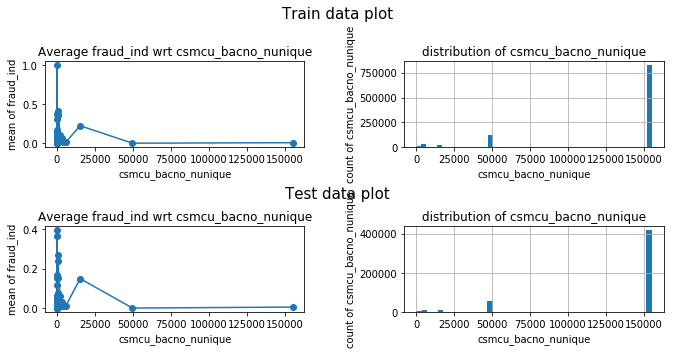

mchno_cano_nunique


<Figure size 432x288 with 0 Axes>

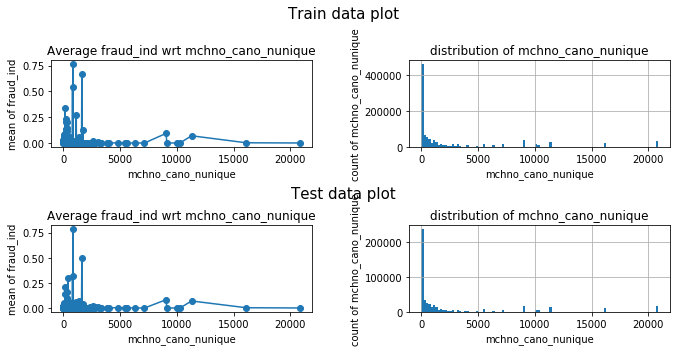

acqic_cano_nunique


<Figure size 432x288 with 0 Axes>

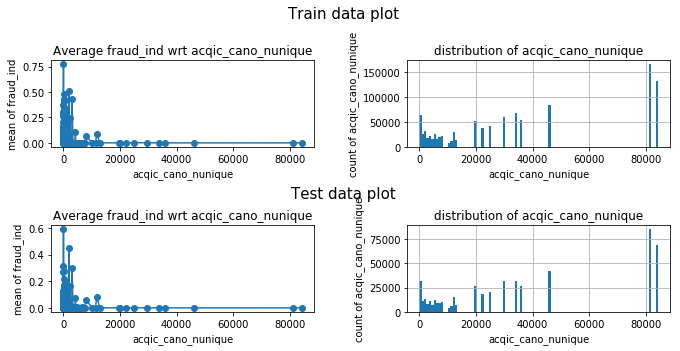

mcc_cano_nunique


<Figure size 432x288 with 0 Axes>

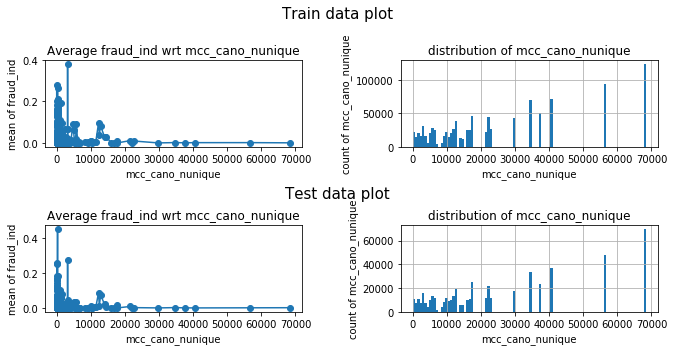

stocn_cano_nunique


<Figure size 432x288 with 0 Axes>

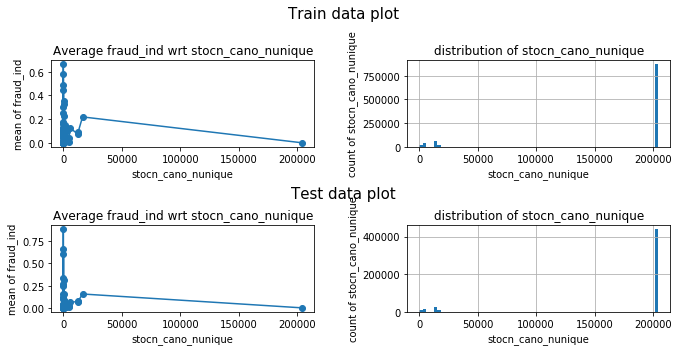

scity_cano_nunique


<Figure size 432x288 with 0 Axes>

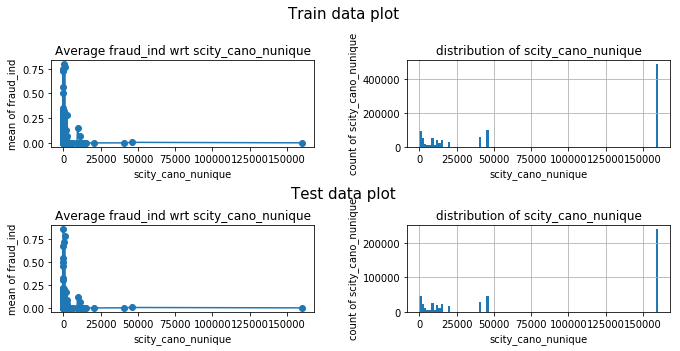

csmcu_cano_nunique


<Figure size 432x288 with 0 Axes>

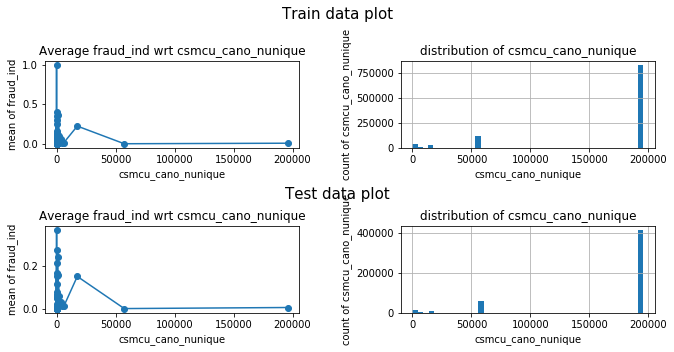

bacno_stocn_nunique


<Figure size 432x288 with 0 Axes>

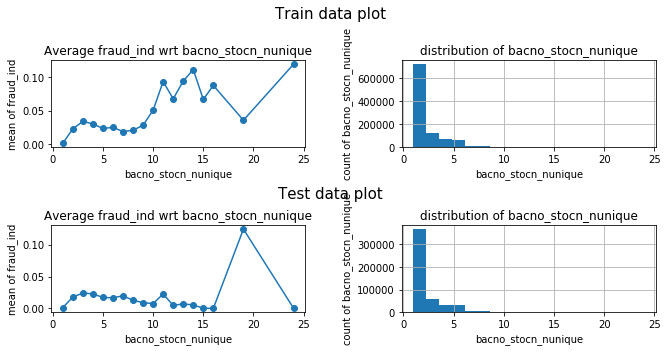

stocn_value_counts


<Figure size 432x288 with 0 Axes>

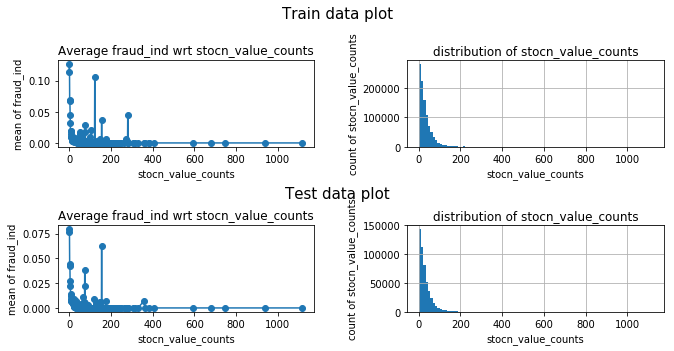

bacno_csmcu_nunique


<Figure size 432x288 with 0 Axes>

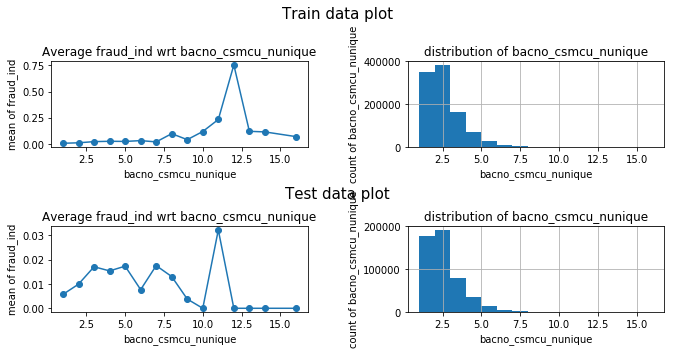

csmcu_value_counts


<Figure size 432x288 with 0 Axes>

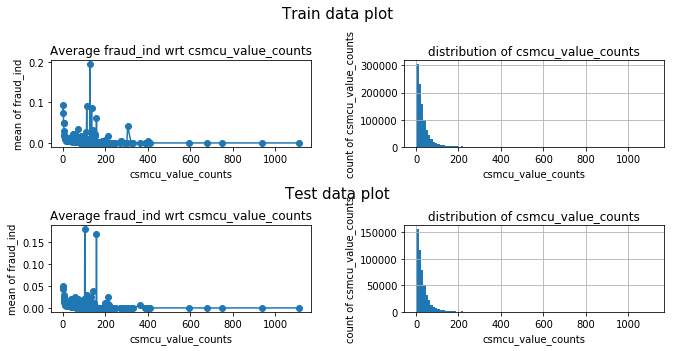

cano_only_consecutive_stscd2


<Figure size 432x288 with 0 Axes>

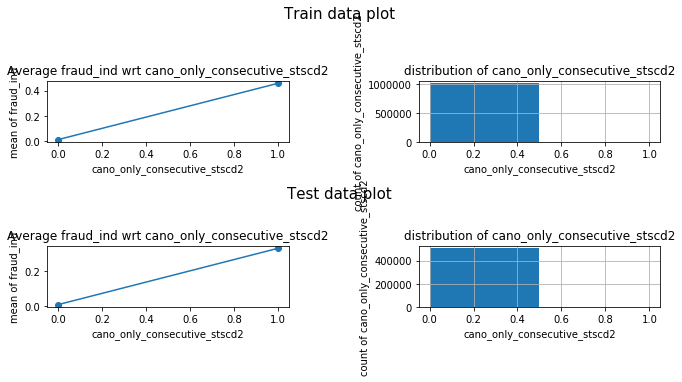

bacno_consecutive_and_only_ecfg


<Figure size 432x288 with 0 Axes>

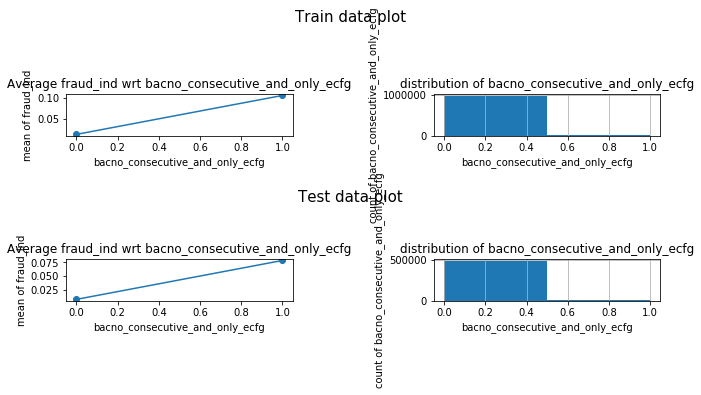

cano_lastday_use


<Figure size 432x288 with 0 Axes>

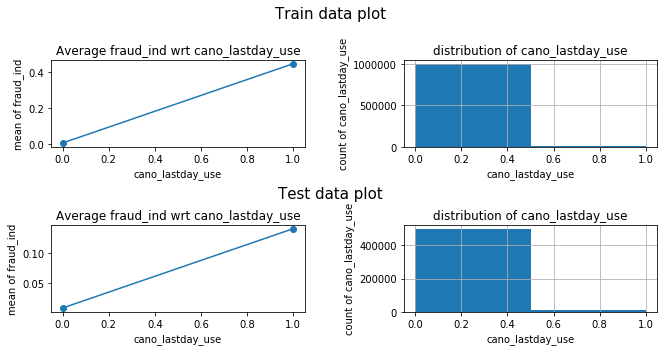

cano_lastday_use_twokind


<Figure size 432x288 with 0 Axes>

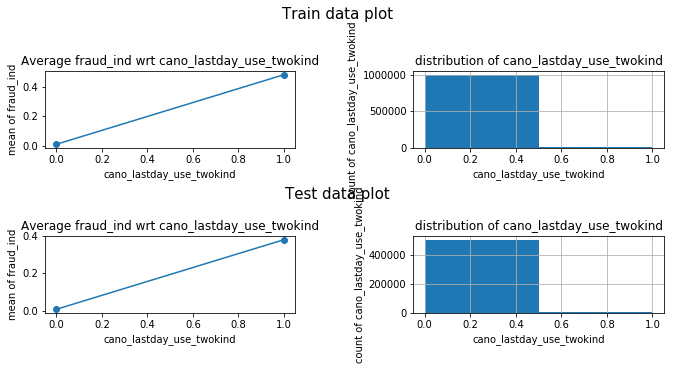

cano_lastlocdt


<Figure size 432x288 with 0 Axes>

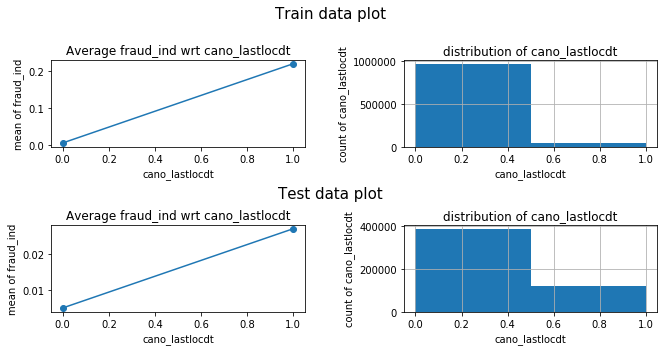

bacno_lastlocdt


<Figure size 432x288 with 0 Axes>

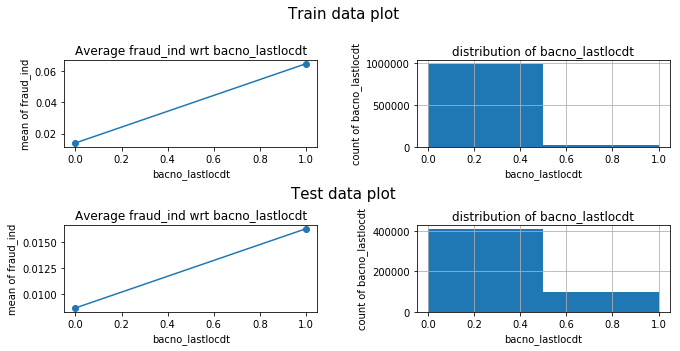

cano_lastlocdt2


<Figure size 432x288 with 0 Axes>

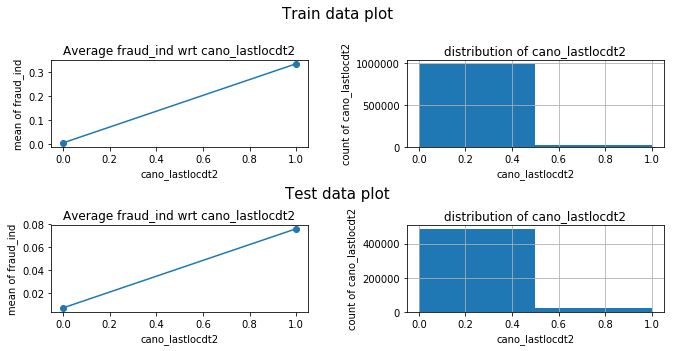

bacno_stscd_equal2


<Figure size 432x288 with 0 Axes>

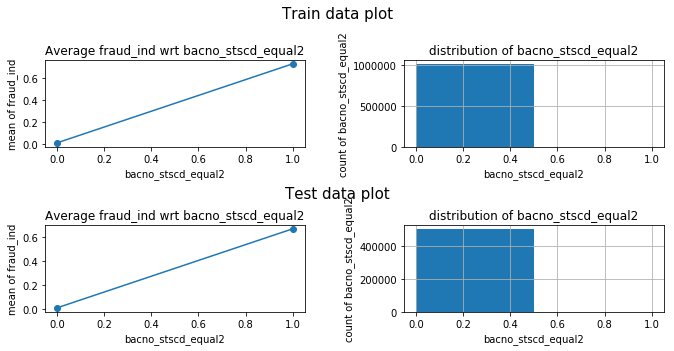

bacno_ecfg_equal1


<Figure size 432x288 with 0 Axes>

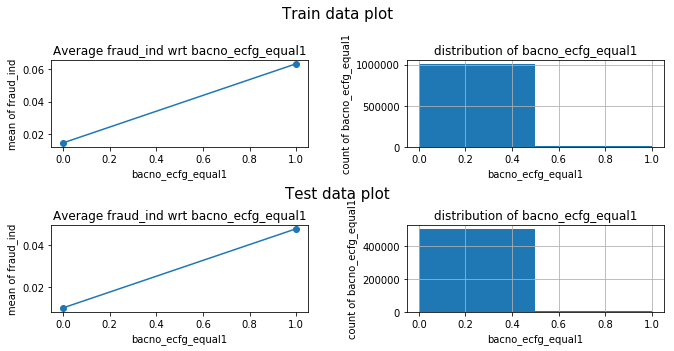

In [5]:
train_d = all_data[all_data['locdt']<=60]
valid_d = all_data[(all_data['locdt']>60)&(all_data['locdt']<=90)]
# 自己做的圖表function，畵資料分佈的bar chart和對fraud_ind的關係

for c in train_d.columns:
    analze_distribution(train_d,'fraud_ind',c,valid_d)


from featexp import get_univariate_plots
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['hcefg'], bins=100, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['loctm_hr'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['flg_3dsmk'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['csmcu'], bins=100, data_test=valid_d)

## 檢查train和test data的分佈有哪裡不一樣

acqic
nunique train 6051
nunique test 3748
max train 6884
max test 6884


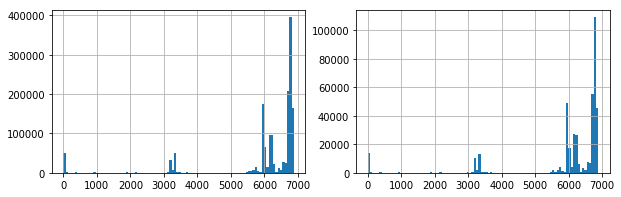

bacno
nunique train 95214
nunique test 71099
max train 163884
max test 163886


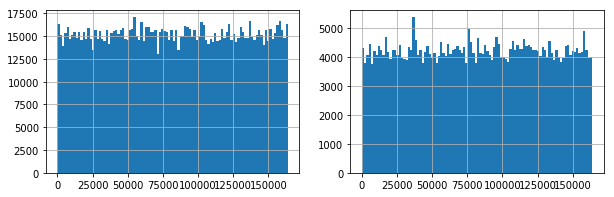

cano
nunique train 129413
nunique test 86808
max train 213334
max test 213575


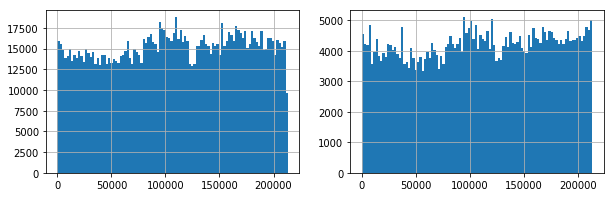

conam
nunique train 72961
nunique test 31977
max train 7208.77
max test 6728.97


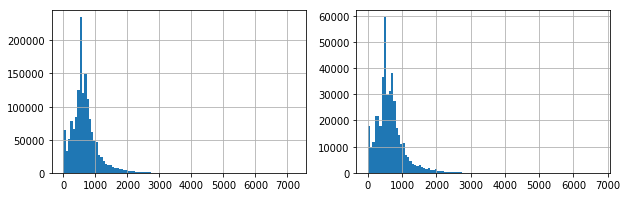

contp
nunique train 7
nunique test 7
max train 6
max test 6


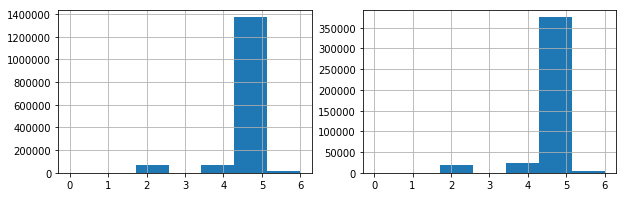

csmcu
nunique train 72
nunique test 57
max train 75
max test 75


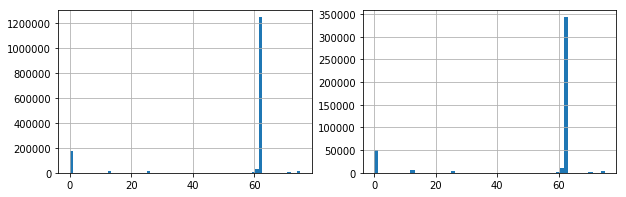

ecfg
nunique train 2
nunique test 2
max train 1
max test 1


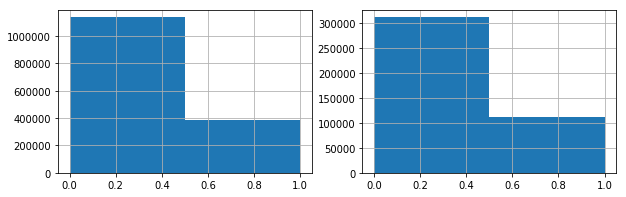

etymd
nunique train 11
nunique test 11
max train 10
max test 10


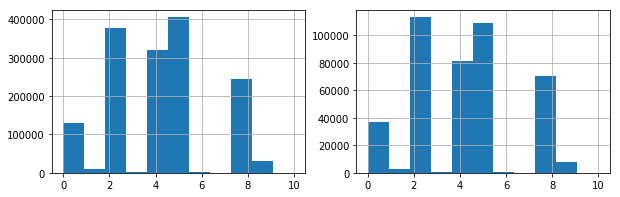

flbmk
nunique train 3
nunique test 3
max train 1.0
max test 1.0


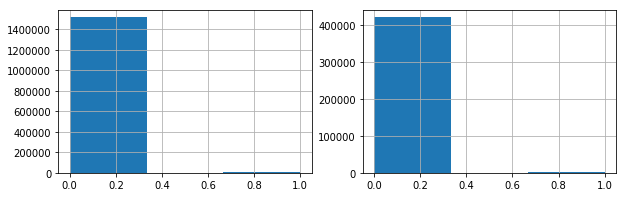

flg_3dsmk
nunique train 3
nunique test 3
max train 1.0
max test 1.0


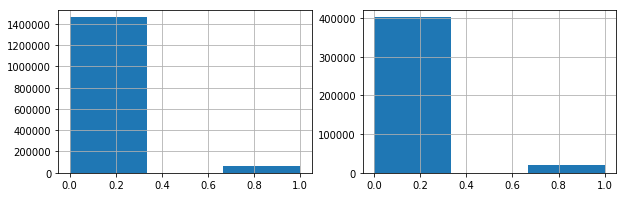

hcefg
nunique train 9
nunique test 10
max train 9
max test 9


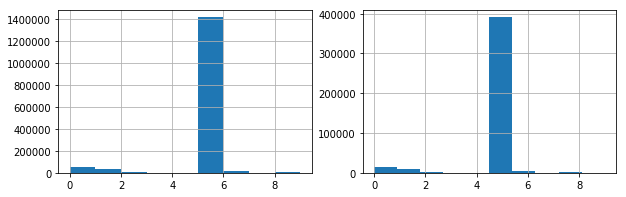

insfg
nunique train 2
nunique test 2
max train 1
max test 1


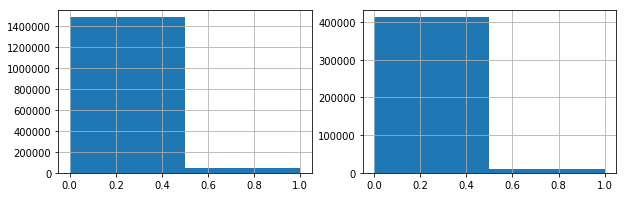

iterm
nunique train 9
nunique test 9
max train 8
max test 8


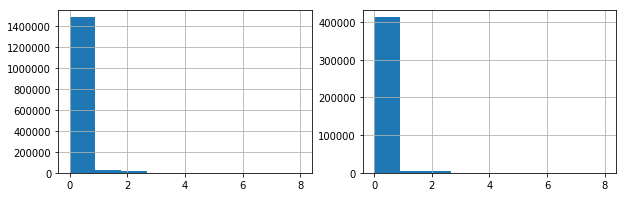

locdt
nunique train 90
nunique test 30
max train 90
max test 120


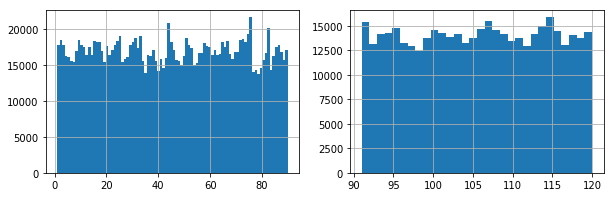

loctm
nunique train 84810
nunique test 75210
max train 235959
max test 235959


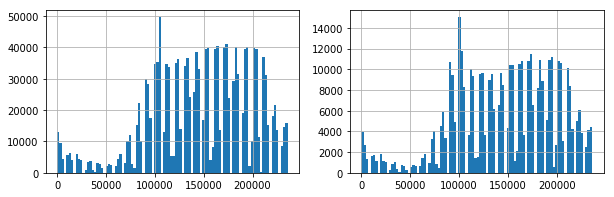

mcc
nunique train 434
nunique test 372
max train 459
max test 459


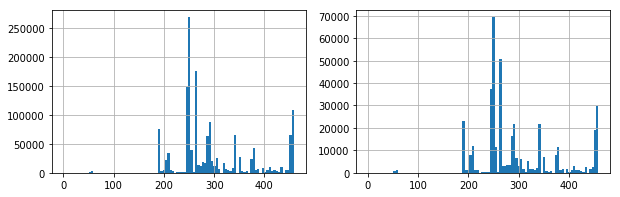

mchno
nunique train 89316
nunique test 45501
max train 103307
max test 103307


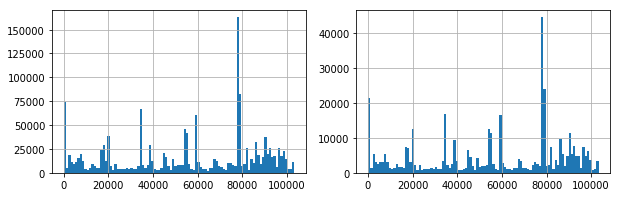

ovrlt
nunique train 2
nunique test 2
max train 1
max test 1


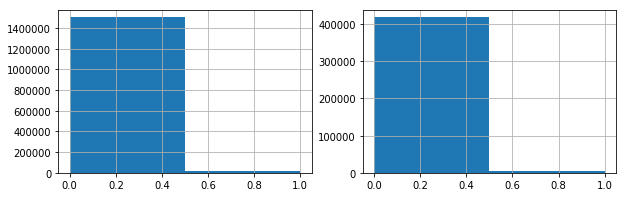

scity
nunique train 5698
nunique test 2857
max train 6671
max test 6670


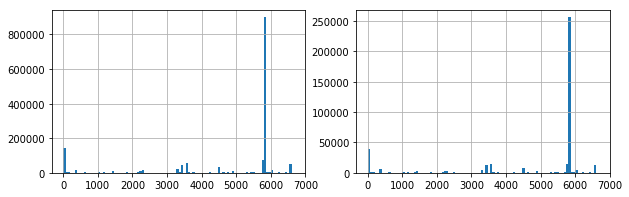

stocn
nunique train 103
nunique test 87
max train 107
max test 108


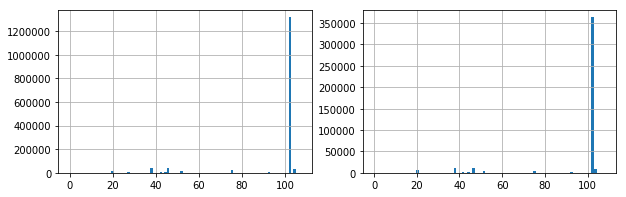

stscd
nunique train 5
nunique test 5
max train 4
max test 4


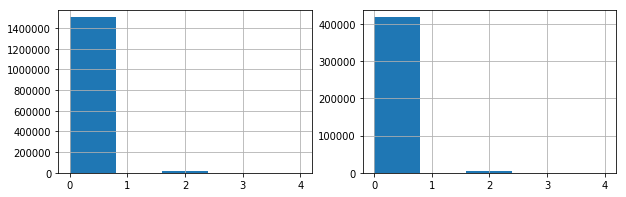

txkey
nunique train 1521787
nunique test 421665
max train 1958239
max test 1959018


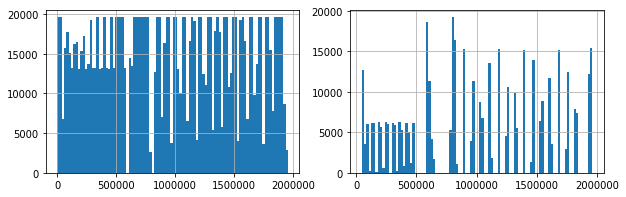

bacno_cano_nunique
nunique train 14
nunique test 13
max train 28
max test 15


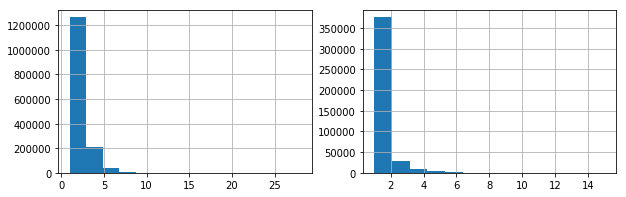

bacno_txkey_nunique
nunique train 268
nunique test 171
max train 1117
max test 983


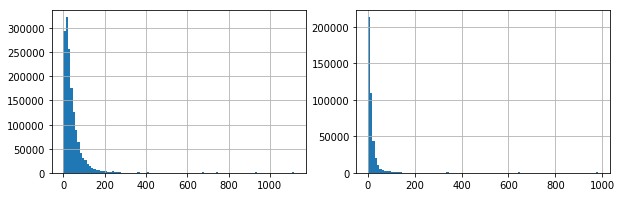

conam_log
nunique train 72961
nunique test 31977
max train 8.8833310206932
max test 8.814474543010734


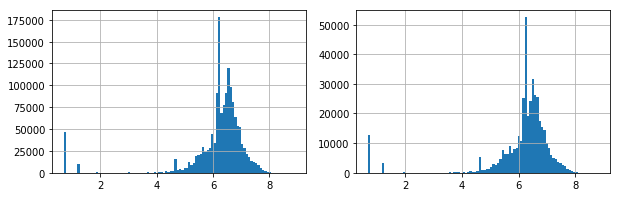

bacno_mean_conam
nunique train 88835
nunique test 58423
max train 8.814474543010734
max test 8.604932969723869


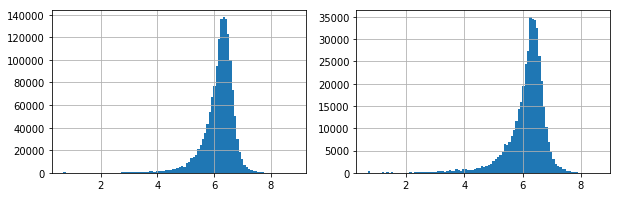

bacno_scale_conam
nunique train 1158913
nunique test 334804
max train 6.467199901131175
max test 6.0306240752530975


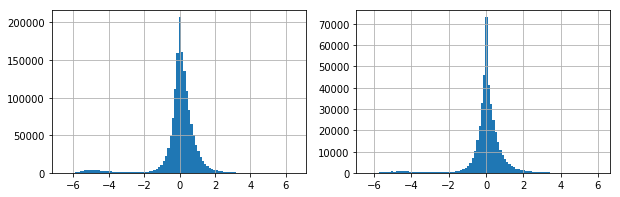

cano_mean_conam
nunique train 111373
nunique test 64011
max train 6728.97
max test 5456.52


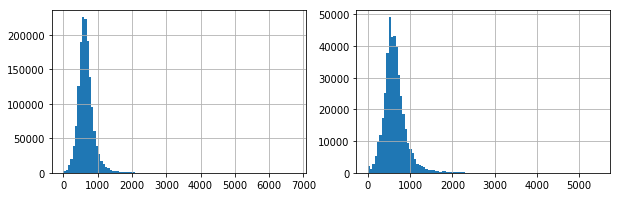

cano_scale_conam
nunique train 1138684
nunique test 318168
max train 5878.421034482759
max test 4572.242


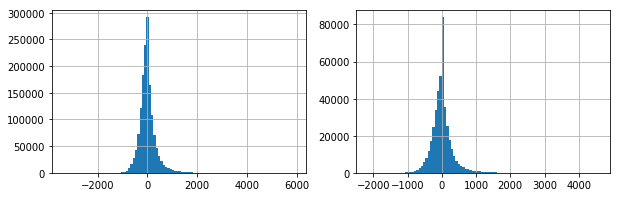

cano_conam_skew
nunique train 94471
nunique test 46405
max train 21.787801710032376
max test 8.452604904428956


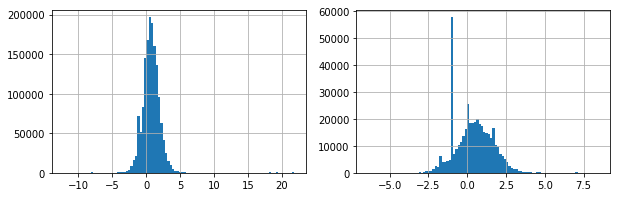

cano_conam_kurt
nunique train 85902
nunique test 37925
max train 498.92018883033137
max test 112.90240921193308


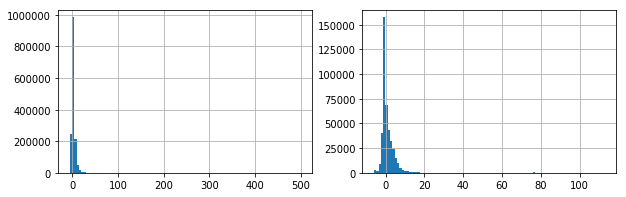

cano_conam_mean
nunique train 111373
nunique test 64011
max train 6728.97
max test 5456.52


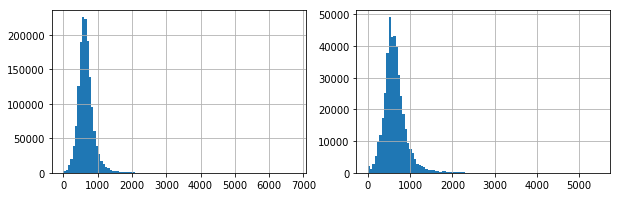

cano_conam_var
nunique train 106857
nunique test 59387
max train 22630233.60405
max test 9001736.651250001


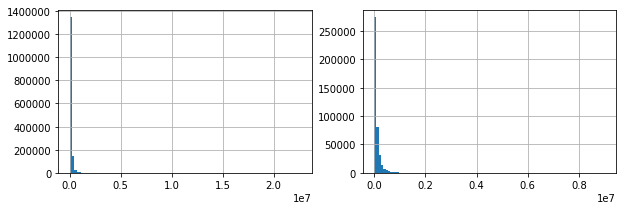

bacno_max_conam
nunique train 26836
nunique test 16881
max train 7208.77
max test 6728.97


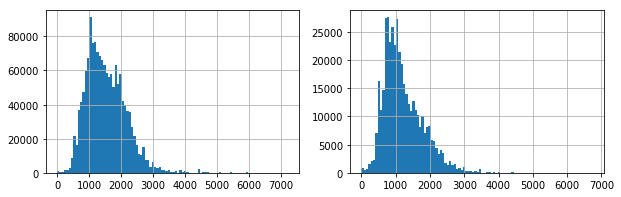

bacno_ismax_conam
nunique train 2
nunique test 2
max train 1
max test 1


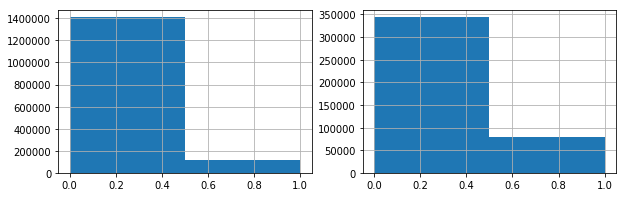

bacno_min_conam
nunique train 7345
nunique test 6886
max train 6728.97
max test 5456.52


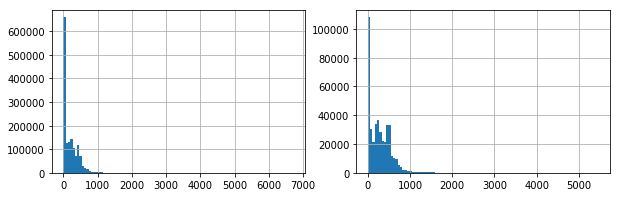

bacno_ismin_conam
nunique train 2
nunique test 2
max train 1
max test 1


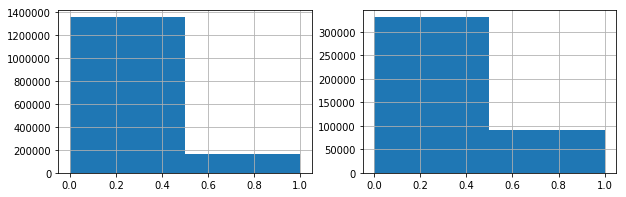

bacno_ratio_ecfg
nunique train 2419
nunique test 945
max train 1.0
max test 1.0


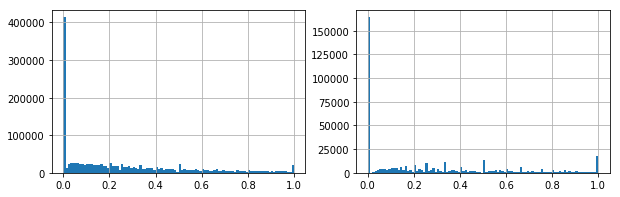

cano_ratio_ecfg
nunique train 1943
nunique test 789
max train 1.0
max test 1.0


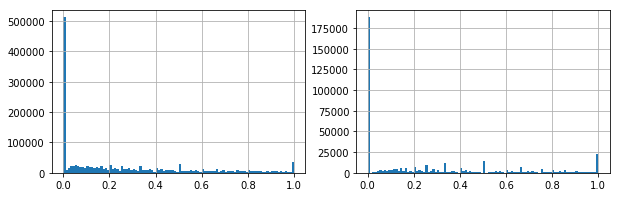

locdt_week
nunique train 7
nunique test 7
max train 7
max test 7


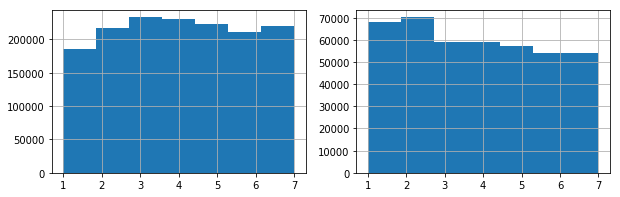

loctm_hr
nunique train 24
nunique test 24
max train 23
max test 23


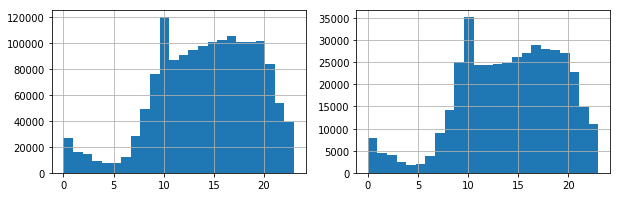

bacno_locdt_skew
nunique train 74170
nunique test 32808
max train 7.937253933193687
max test 4.720965167858198


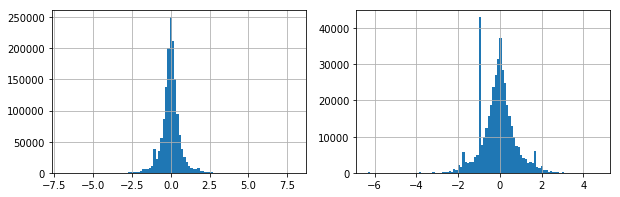

bacno_locdt_kurt
nunique train 71475
nunique test 31350
max train 62.999999999999076
max test 41.06840649002047


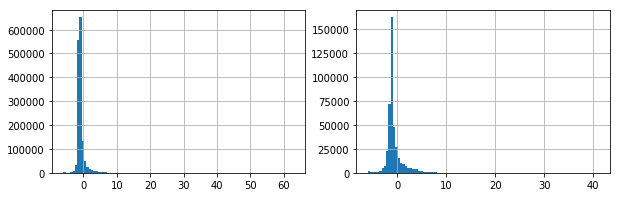

cano_locdt_skew
nunique train 88487
nunique test 33224
max train 8.000000000000002
max test 4.720965167858198


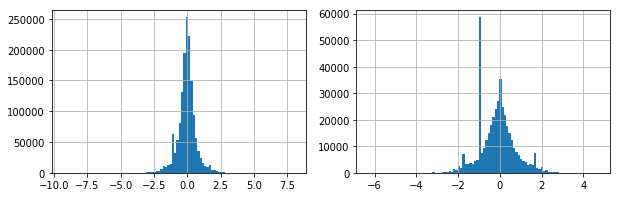

cano_locdt_kurt
nunique train 84848
nunique test 31557
max train 85.99999999999994
max test 41.06840649002047


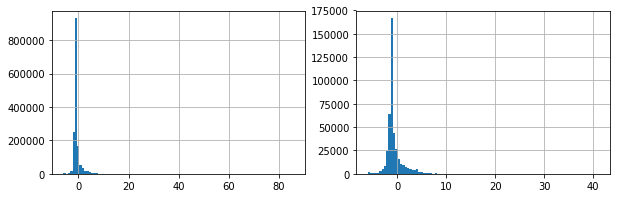

bacno_stocn_mode
nunique train 62
nunique test 61
max train 107
max test 108


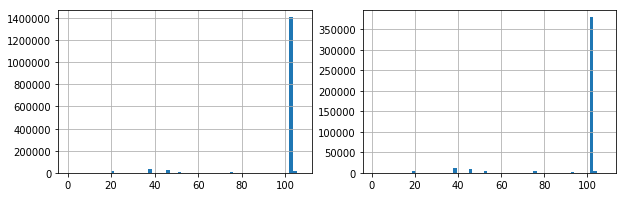

bacno_scity_mode
nunique train 765
nunique test 847
max train 6640
max test 6644


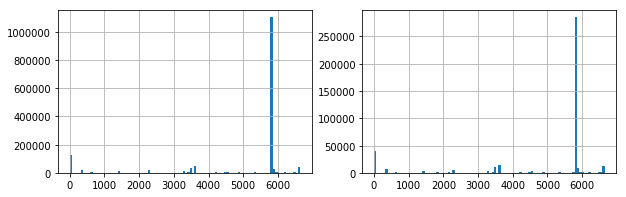

bacno_csmcu_mode
nunique train 42
nunique test 42
max train 75
max test 75


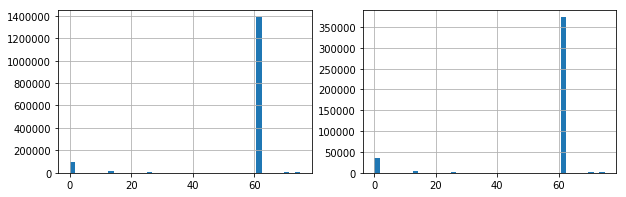

bacno_stocn_ismode
nunique train 2
nunique test 2
max train 1
max test 1


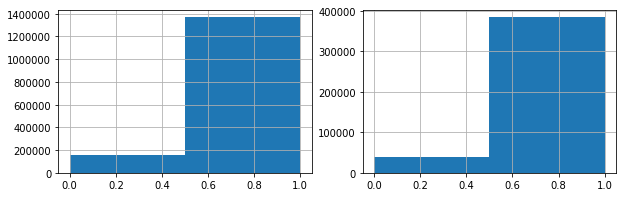

bacno_scity_ismode
nunique train 2
nunique test 2
max train 1
max test 1


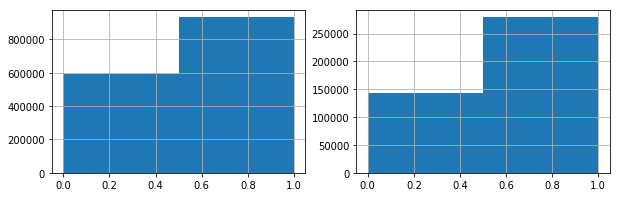

bacno_csmcu_ismode
nunique train 2
nunique test 2
max train 1
max test 1


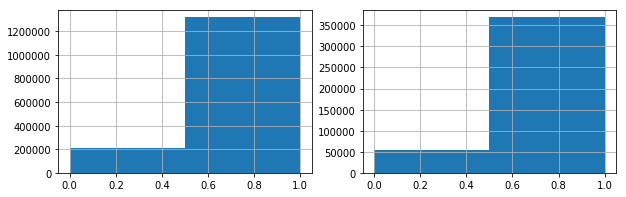

cano_stocn_mode
nunique train 69
nunique test 69
max train 107
max test 108


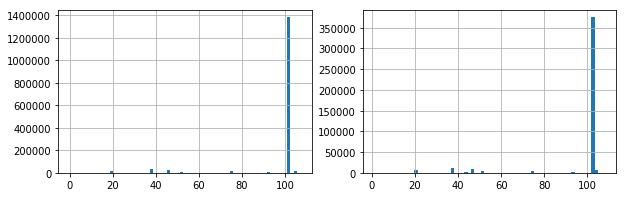

cano_scity_mode
nunique train 1212
nunique test 1035
max train 6665
max test 6644


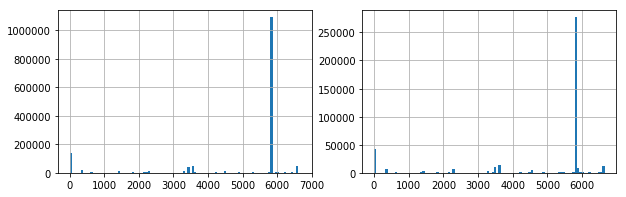

cano_csmcu_mode
nunique train 45
nunique test 43
max train 75
max test 75


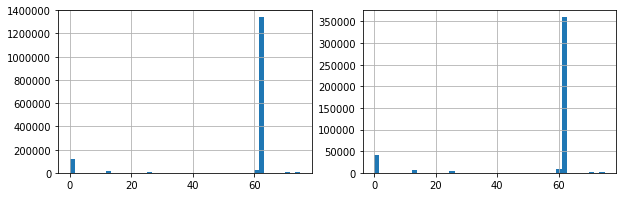

cano_stocn_ismode
nunique train 2
nunique test 2
max train 1
max test 1


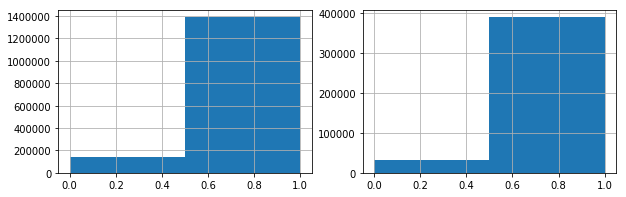

cano_scity_ismode
nunique train 2
nunique test 2
max train 1
max test 1


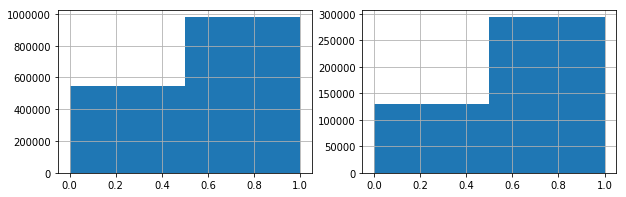

cano_csmcu_ismode
nunique train 2
nunique test 2
max train 1
max test 1


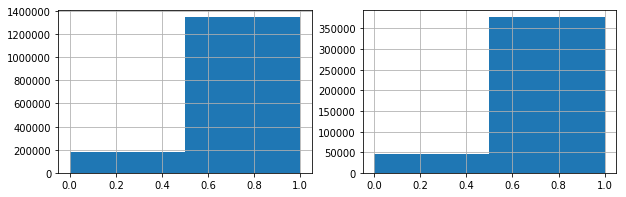

mchno_fraud_mean
nunique train 207
nunique test 163
max train 1.0
max test 1.0


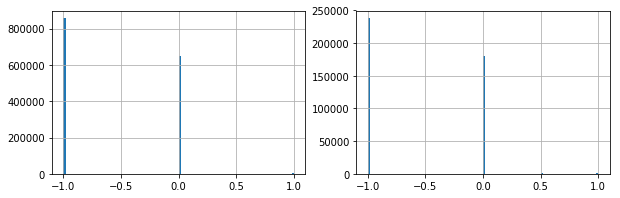

mcc_fraud_mean
nunique train 96
nunique test 79
max train 1.0
max test 1.0


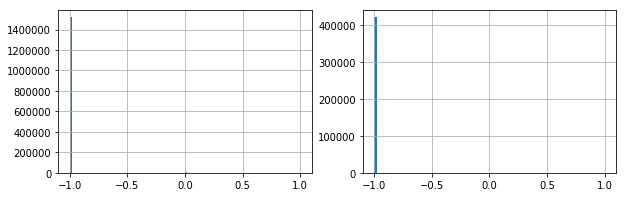

acqic_fraud_mean
nunique train 181
nunique test 141
max train 1.0
max test 1.0


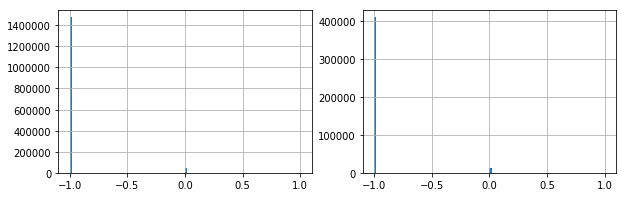

mchno_bacno_nunique
nunique train 580
nunique test 577
max train 20040
max test 20040


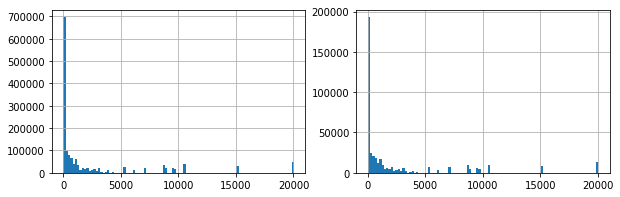

acqic_bacno_nunique
nunique train 259
nunique test 258
max train 74622
max test 74622


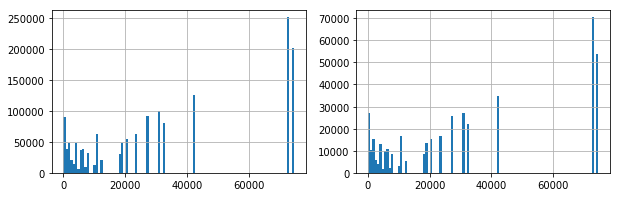

mcc_bacno_nunique
nunique train 215
nunique test 214
max train 62397
max test 62397


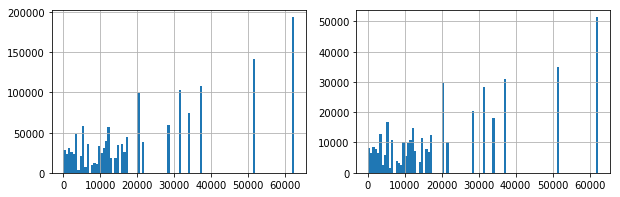

stocn_bacno_nunique
nunique train 60
nunique test 60
max train 159388
max test 159388


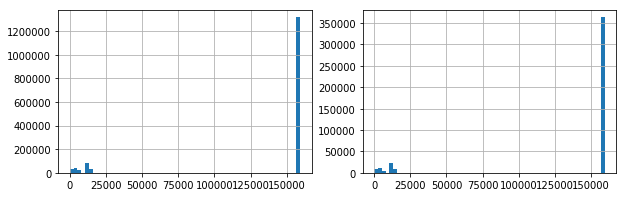

scity_bacno_nunique
nunique train 248
nunique test 247
max train 130881
max test 130881


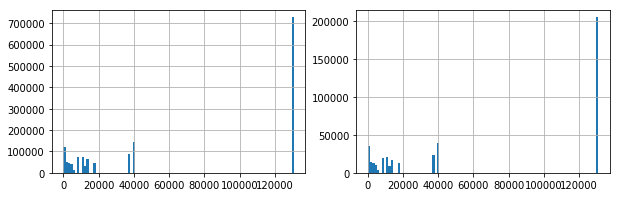

csmcu_bacno_nunique
nunique train 46
nunique test 44
max train 155199
max test 155199


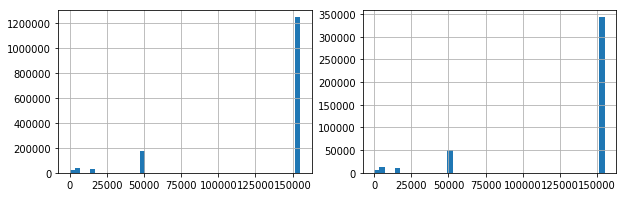

mchno_cano_nunique
nunique train 589
nunique test 585
max train 20869
max test 20869


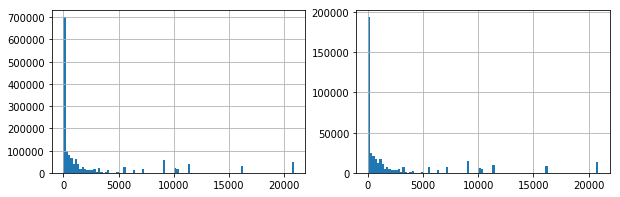

acqic_cano_nunique
nunique train 253
nunique test 251
max train 84353
max test 84353


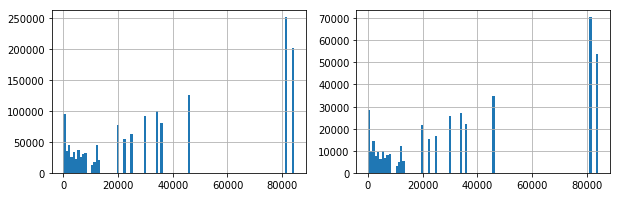

mcc_cano_nunique
nunique train 217
nunique test 217
max train 68408
max test 68408


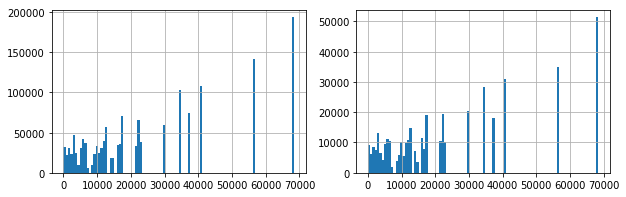

stocn_cano_nunique
nunique train 66
nunique test 66
max train 204341
max test 204341


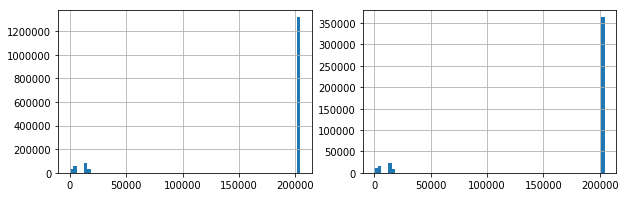

scity_cano_nunique
nunique train 246
nunique test 245
max train 160204
max test 160204


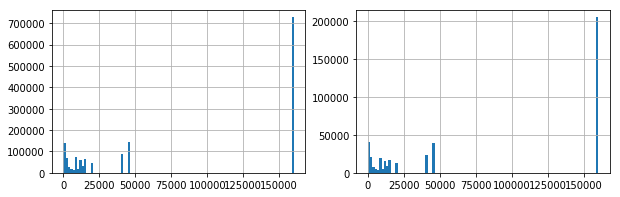

csmcu_cano_nunique
nunique train 44
nunique test 42
max train 195799
max test 195799


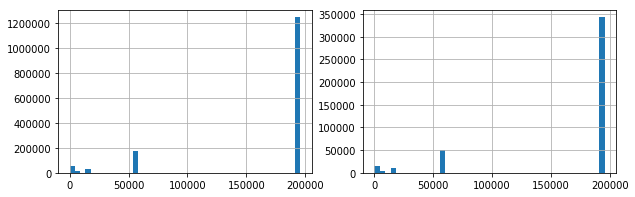

bacno_stocn_nunique
nunique train 18
nunique test 14
max train 24
max test 19


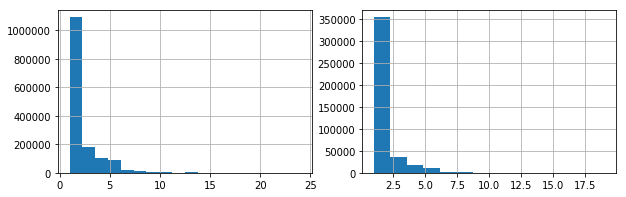

stocn_value_counts
nunique train 227
nunique test 152
max train 1117
max test 983


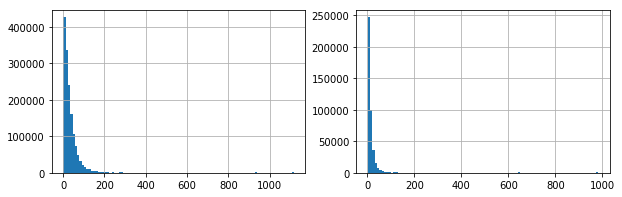

bacno_csmcu_nunique
nunique train 15
nunique test 11
max train 16
max test 11


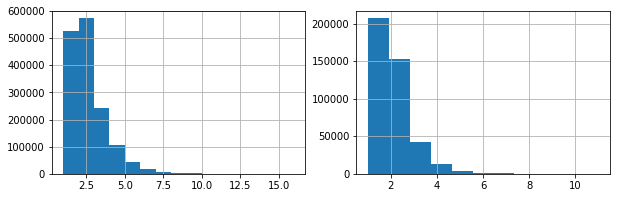

csmcu_value_counts
nunique train 237
nunique test 155
max train 1111
max test 983


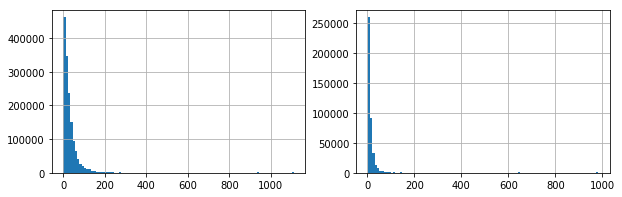

cano_only_consecutive_stscd2
nunique train 2
nunique test 2
max train 1.0
max test 1.0


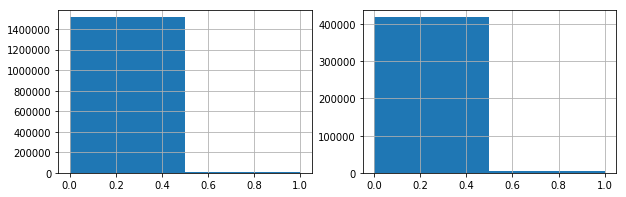

bacno_consecutive_and_only_ecfg
nunique train 2
nunique test 2
max train 1.0
max test 1.0


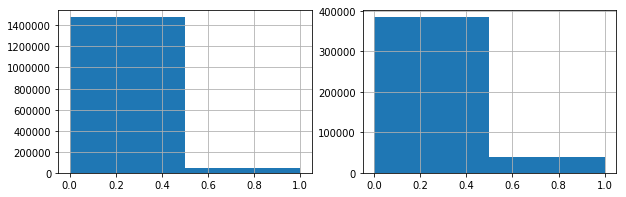

cano_lastday_use
nunique train 2
nunique test 2
max train 1
max test 1


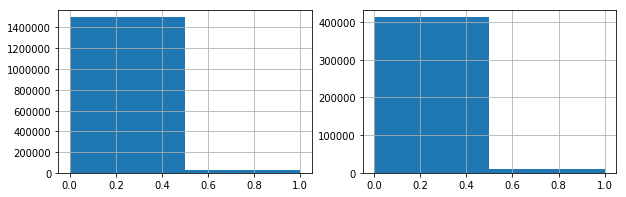

cano_lastday_use_twokind
nunique train 2
nunique test 2
max train 1.0
max test 1.0


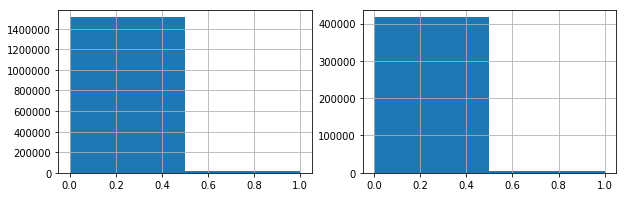

cano_lastlocdt
nunique train 2
nunique test 2
max train 1.0
max test 1.0


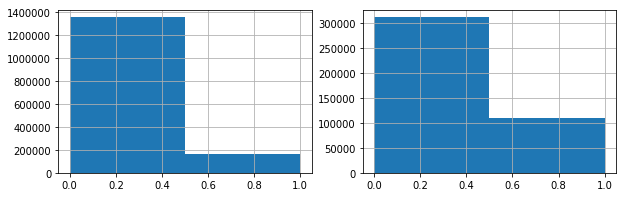

bacno_lastlocdt
nunique train 2
nunique test 2
max train 1.0
max test 1.0


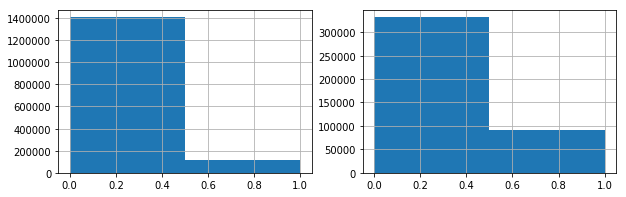

cano_lastlocdt2
nunique train 2
nunique test 2
max train 1
max test 1


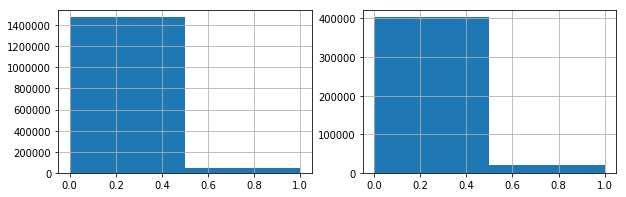

bacno_stscd_equal2
nunique train 2
nunique test 2
max train 1
max test 1


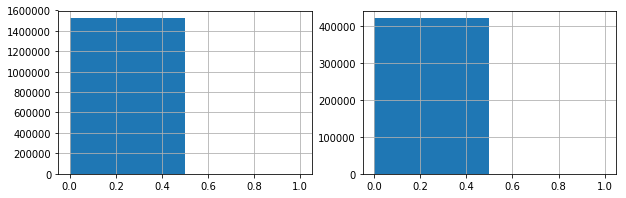

bacno_ecfg_equal1
nunique train 2
nunique test 2
max train 1
max test 1


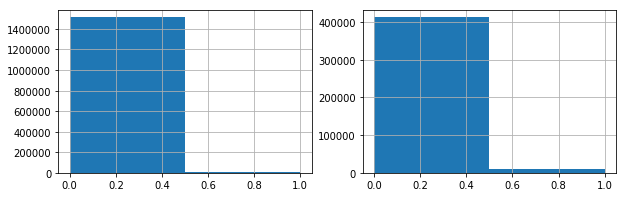

In [6]:
def compare_distribution(train_data,test_data,target_name):
    target = train_data[target_name]
    target2 = test_data[target_name]
    print(target_name)
    print('nunique train',target.nunique())
    print('nunique test',target2.nunique())
    print('max train',target.max())
    print('max test',target2.max())

    fig, axs = plt.subplots(1,2,figsize=(10,3))
    
    bins = target.nunique() if target.nunique()<100 else 100
    target.hist(bins=bins,ax=axs[0])
    
    bins = target2.nunique() if target2.nunique()<100 else 100
    target2.hist(bins=bins,ax=axs[1])
    plt.show()


for c in all_data.drop(columns='fraud_ind'):
    compare_distribution(all_data[all_data['locdt']<=90].drop(columns='fraud_ind'),all_data[all_data['locdt']>90].drop(columns='fraud_ind'),c)

## fraud資料和normal資料的各個特徵差異

acqic


<Figure size 432x288 with 0 Axes>

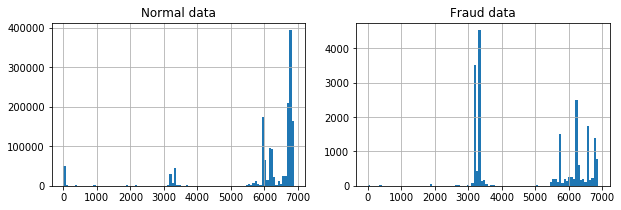

bacno


<Figure size 432x288 with 0 Axes>

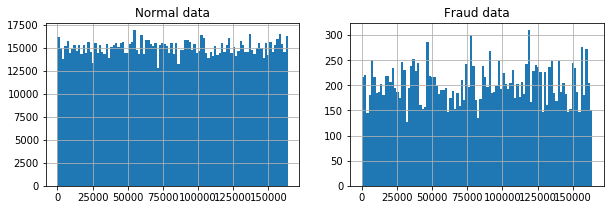

cano


<Figure size 432x288 with 0 Axes>

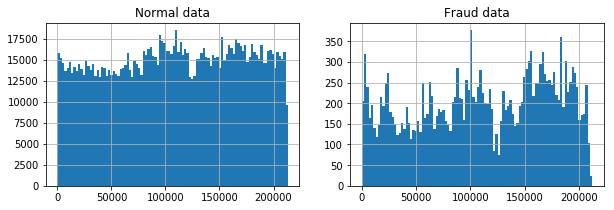

conam


<Figure size 432x288 with 0 Axes>

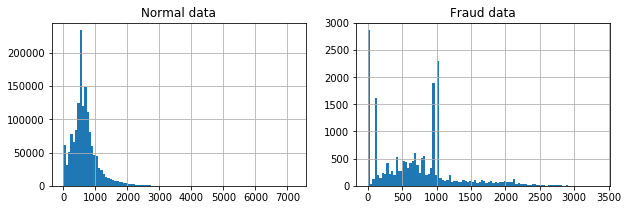

contp


<Figure size 432x288 with 0 Axes>

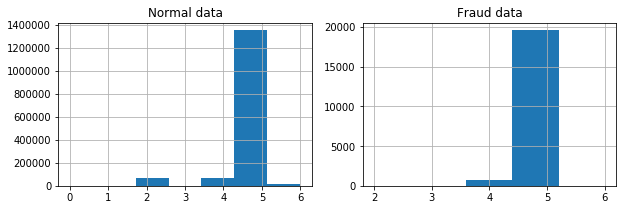

csmcu


<Figure size 432x288 with 0 Axes>

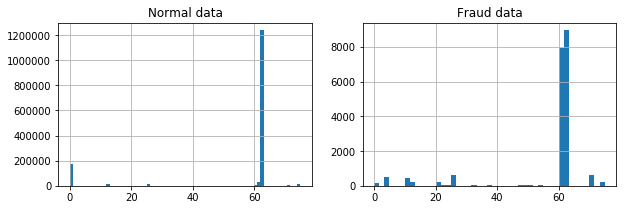

ecfg


<Figure size 432x288 with 0 Axes>

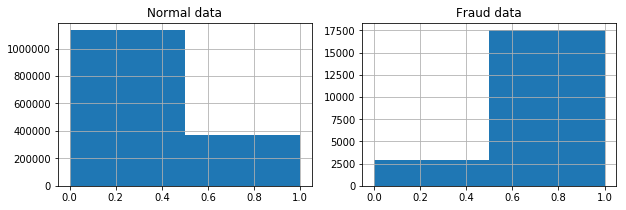

etymd


<Figure size 432x288 with 0 Axes>

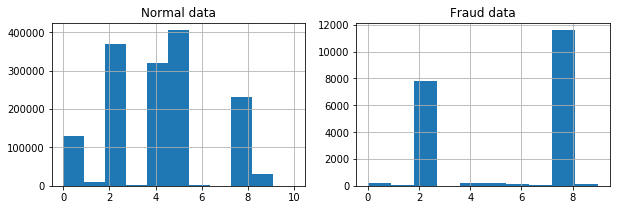

flbmk


<Figure size 432x288 with 0 Axes>

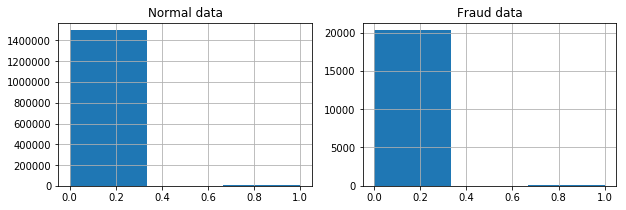

flg_3dsmk


<Figure size 432x288 with 0 Axes>

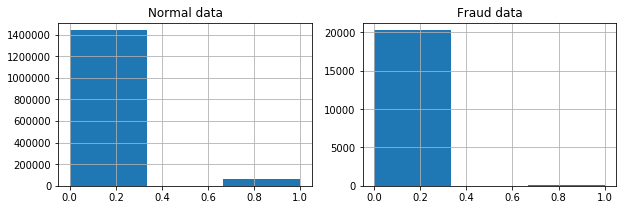

fraud_ind


<Figure size 432x288 with 0 Axes>

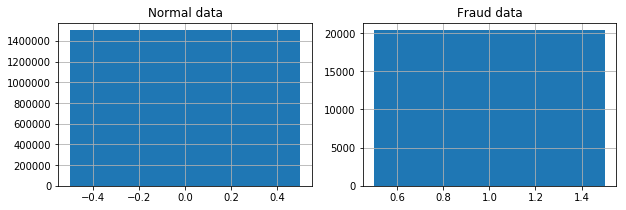

hcefg


<Figure size 432x288 with 0 Axes>

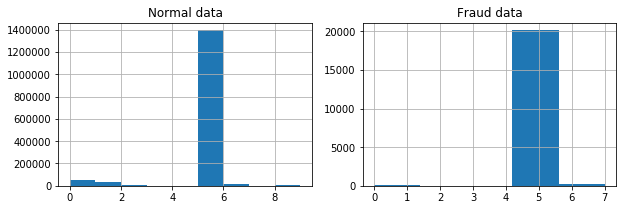

insfg


<Figure size 432x288 with 0 Axes>

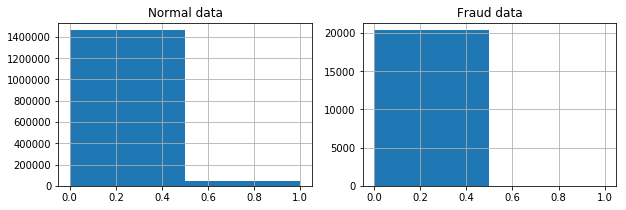

iterm


<Figure size 432x288 with 0 Axes>

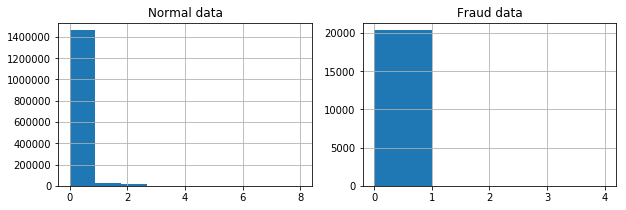

locdt


<Figure size 432x288 with 0 Axes>

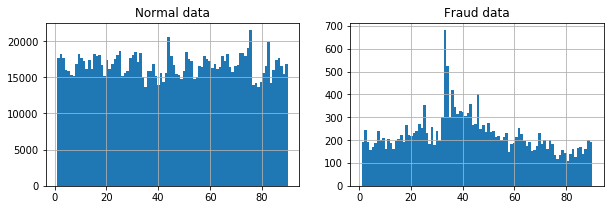

loctm


<Figure size 432x288 with 0 Axes>

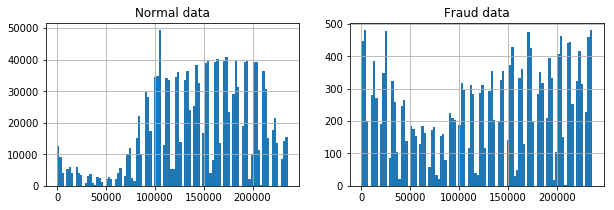

mcc


<Figure size 432x288 with 0 Axes>

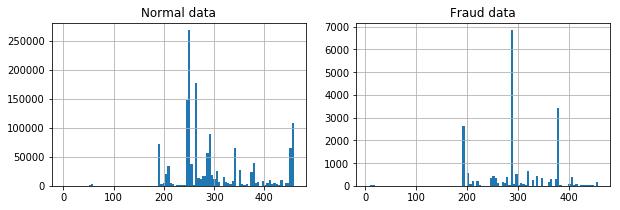

mchno


<Figure size 432x288 with 0 Axes>

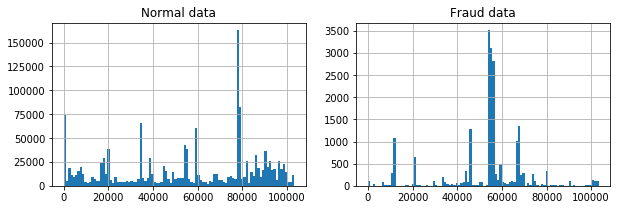

ovrlt


<Figure size 432x288 with 0 Axes>

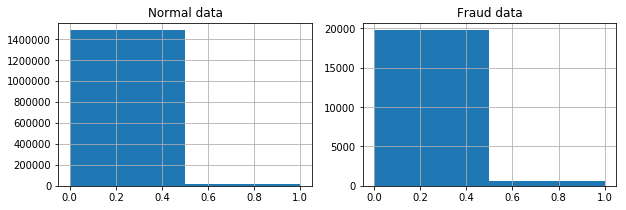

scity


<Figure size 432x288 with 0 Axes>

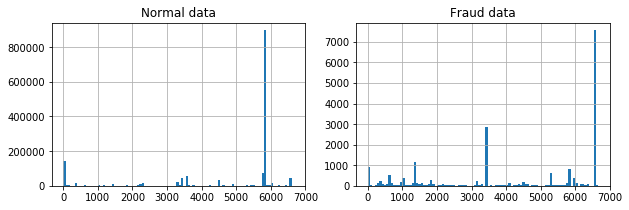

stocn


<Figure size 432x288 with 0 Axes>

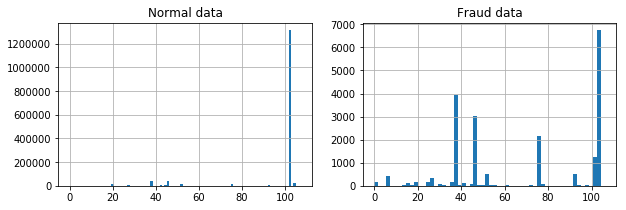

stscd


<Figure size 432x288 with 0 Axes>

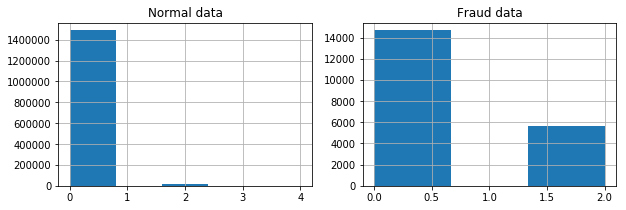

txkey


<Figure size 432x288 with 0 Axes>

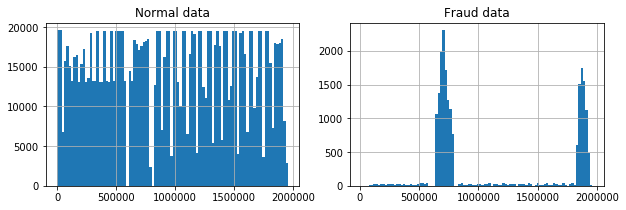

bacno_cano_nunique


<Figure size 432x288 with 0 Axes>

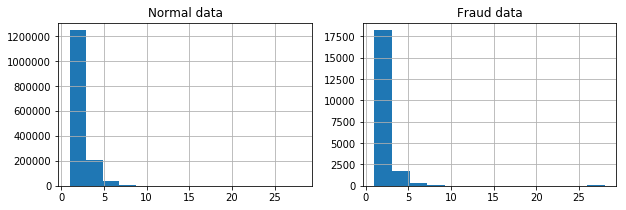

bacno_txkey_nunique


<Figure size 432x288 with 0 Axes>

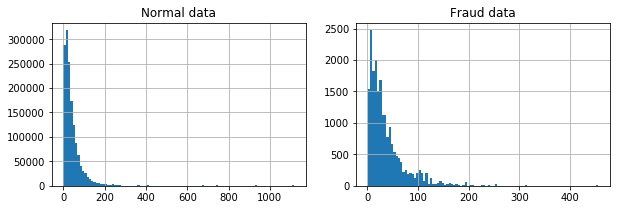

conam_log


<Figure size 432x288 with 0 Axes>

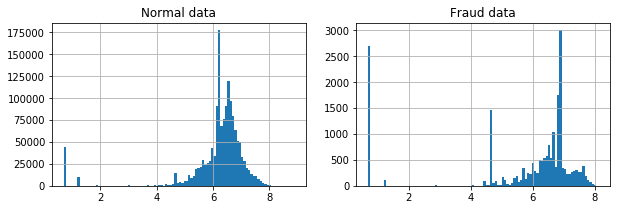

bacno_mean_conam


<Figure size 432x288 with 0 Axes>

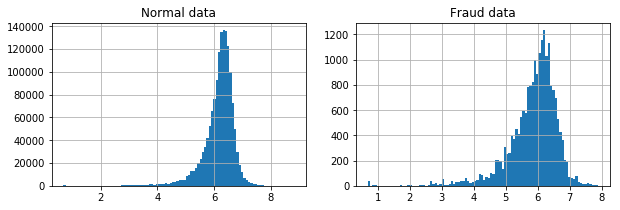

bacno_scale_conam


<Figure size 432x288 with 0 Axes>

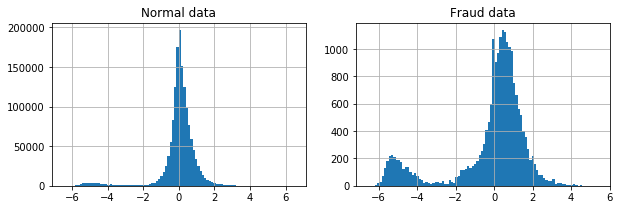

cano_mean_conam


<Figure size 432x288 with 0 Axes>

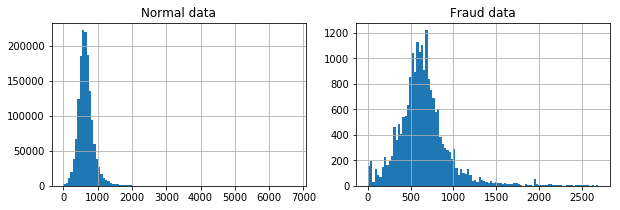

cano_scale_conam


<Figure size 432x288 with 0 Axes>

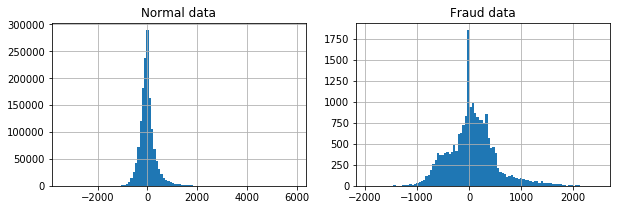

cano_conam_skew


<Figure size 432x288 with 0 Axes>

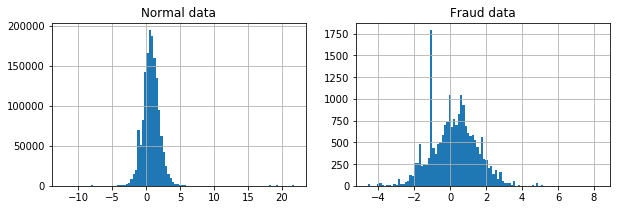

cano_conam_kurt


<Figure size 432x288 with 0 Axes>

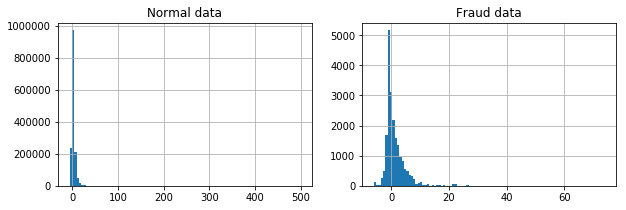

cano_conam_mean


<Figure size 432x288 with 0 Axes>

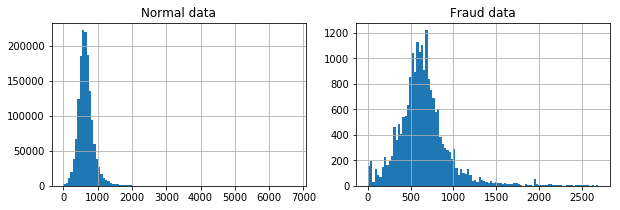

cano_conam_var


<Figure size 432x288 with 0 Axes>

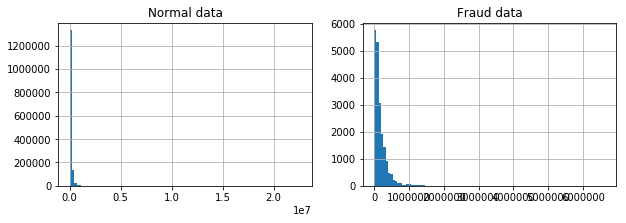

bacno_max_conam


<Figure size 432x288 with 0 Axes>

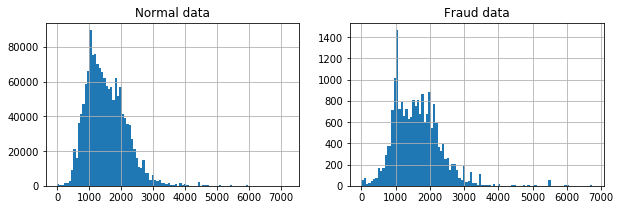

bacno_ismax_conam


<Figure size 432x288 with 0 Axes>

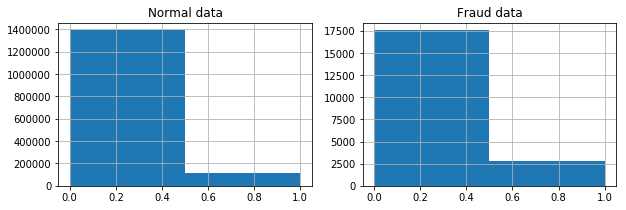

bacno_min_conam


<Figure size 432x288 with 0 Axes>

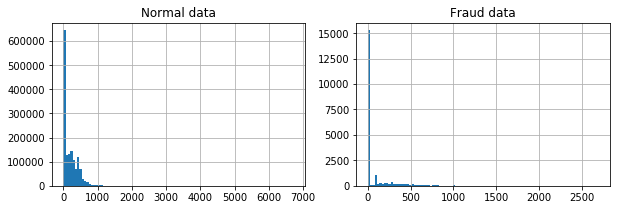

bacno_ismin_conam


<Figure size 432x288 with 0 Axes>

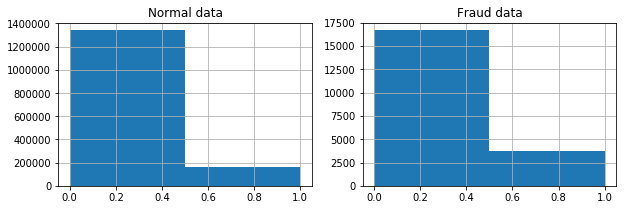

bacno_ratio_ecfg


<Figure size 432x288 with 0 Axes>

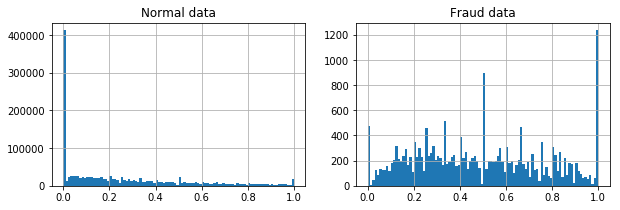

cano_ratio_ecfg


<Figure size 432x288 with 0 Axes>

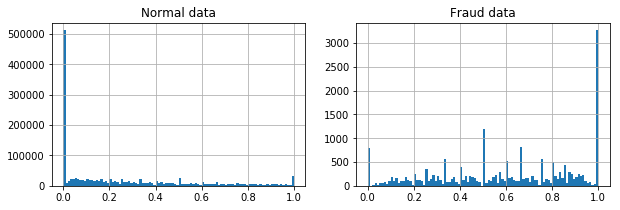

locdt_week


<Figure size 432x288 with 0 Axes>

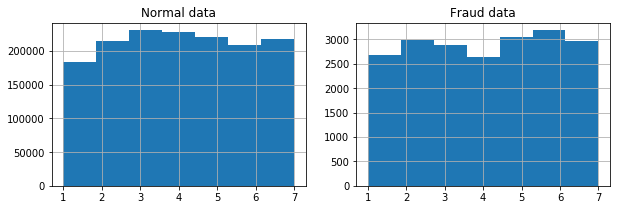

loctm_hr


<Figure size 432x288 with 0 Axes>

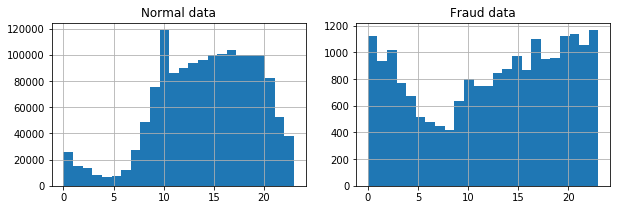

bacno_locdt_skew


<Figure size 432x288 with 0 Axes>

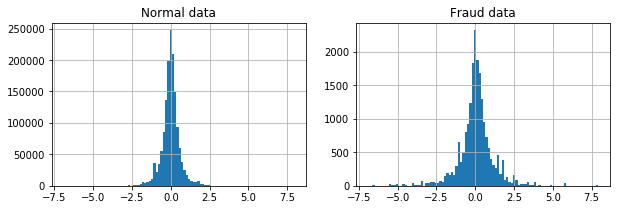

bacno_locdt_kurt


<Figure size 432x288 with 0 Axes>

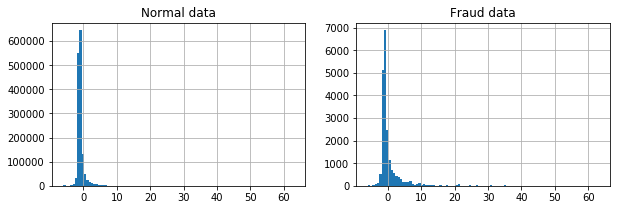

cano_locdt_skew


<Figure size 432x288 with 0 Axes>

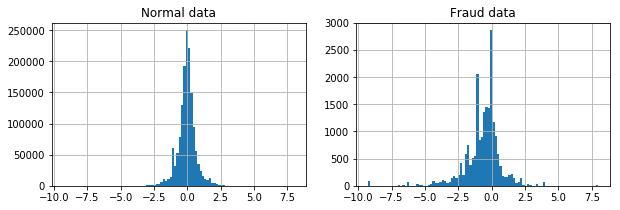

cano_locdt_kurt


<Figure size 432x288 with 0 Axes>

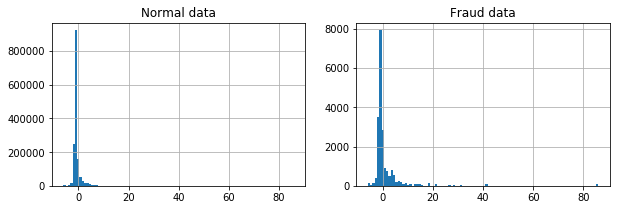

bacno_stocn_mode


<Figure size 432x288 with 0 Axes>

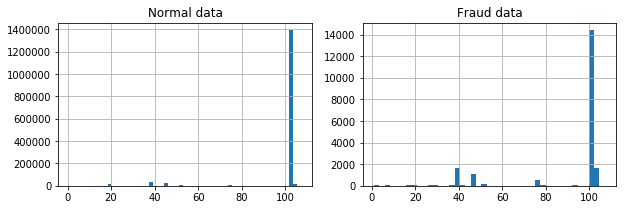

bacno_scity_mode


<Figure size 432x288 with 0 Axes>

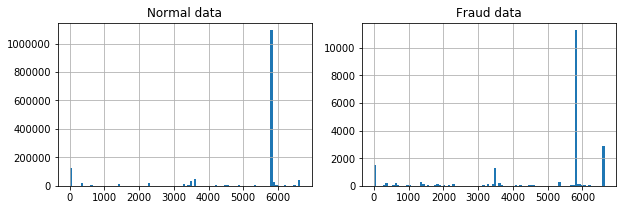

bacno_csmcu_mode


<Figure size 432x288 with 0 Axes>

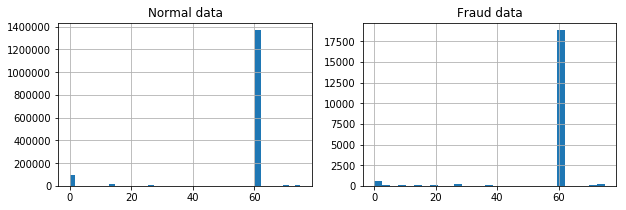

bacno_stocn_ismode


<Figure size 432x288 with 0 Axes>

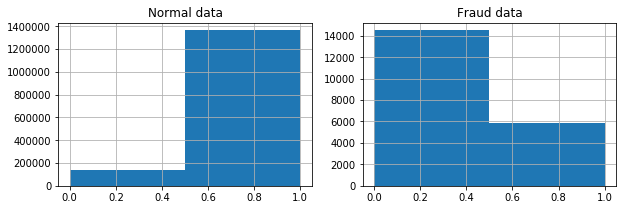

bacno_scity_ismode


<Figure size 432x288 with 0 Axes>

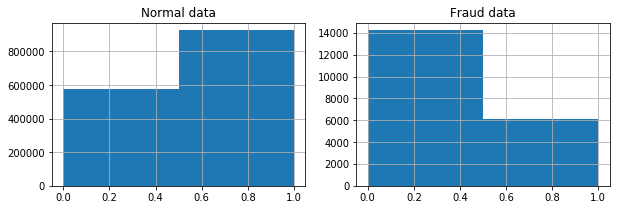

bacno_csmcu_ismode


<Figure size 432x288 with 0 Axes>

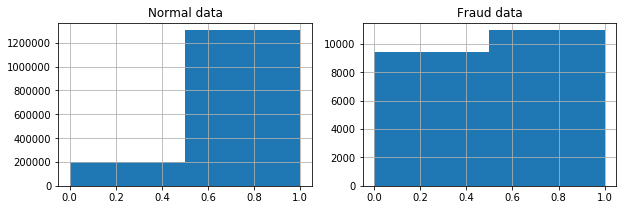

cano_stocn_mode


<Figure size 432x288 with 0 Axes>

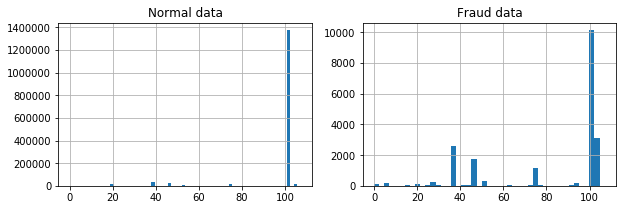

cano_scity_mode


<Figure size 432x288 with 0 Axes>

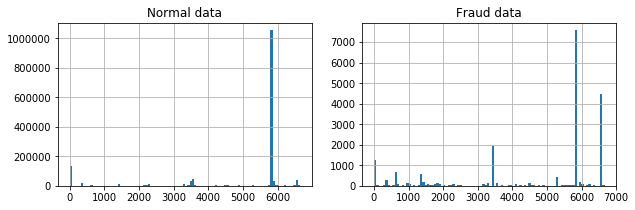

cano_csmcu_mode


<Figure size 432x288 with 0 Axes>

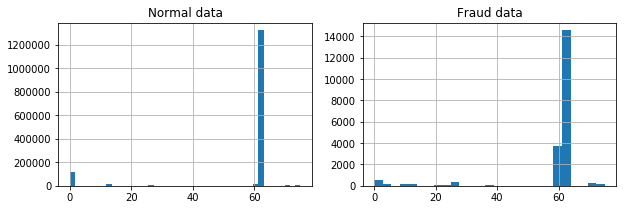

cano_stocn_ismode


<Figure size 432x288 with 0 Axes>

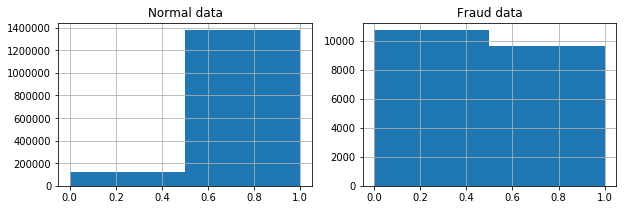

cano_scity_ismode


<Figure size 432x288 with 0 Axes>

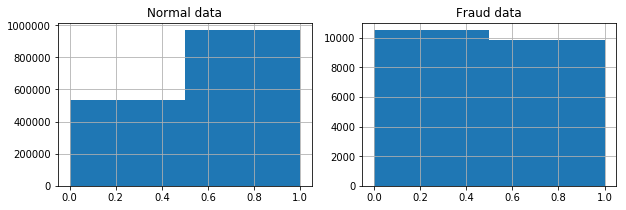

cano_csmcu_ismode


<Figure size 432x288 with 0 Axes>

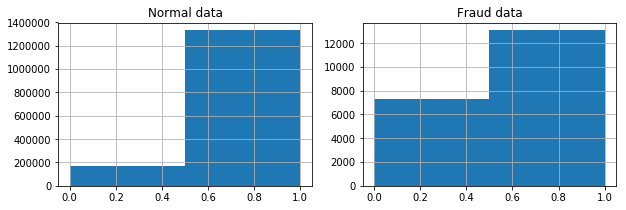

mchno_fraud_mean


<Figure size 432x288 with 0 Axes>

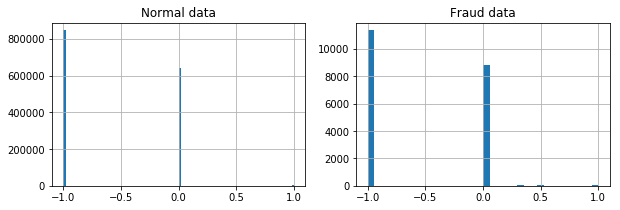

mcc_fraud_mean


<Figure size 432x288 with 0 Axes>

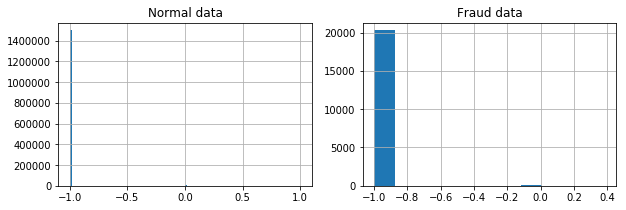

acqic_fraud_mean


<Figure size 432x288 with 0 Axes>

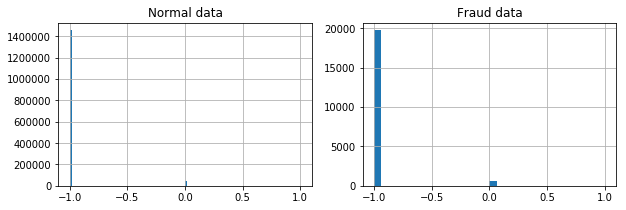

mchno_bacno_nunique


<Figure size 432x288 with 0 Axes>

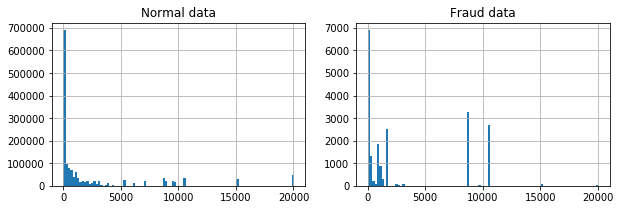

acqic_bacno_nunique


<Figure size 432x288 with 0 Axes>

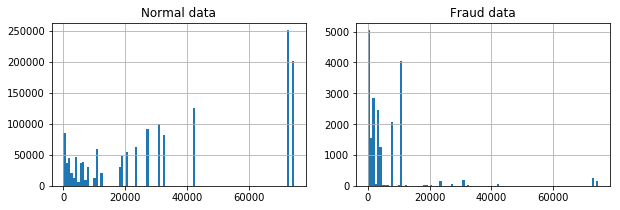

mcc_bacno_nunique


<Figure size 432x288 with 0 Axes>

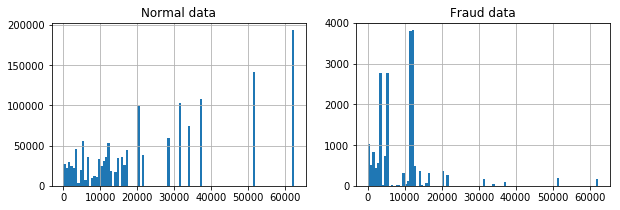

stocn_bacno_nunique


<Figure size 432x288 with 0 Axes>

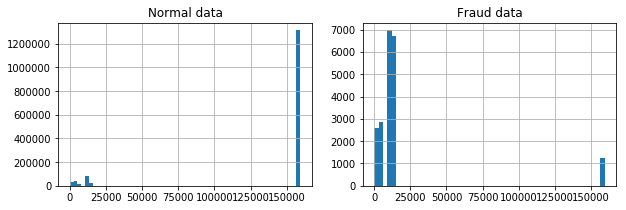

scity_bacno_nunique


<Figure size 432x288 with 0 Axes>

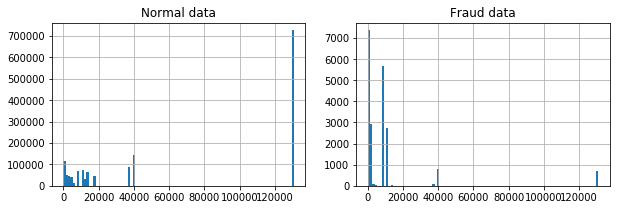

csmcu_bacno_nunique


<Figure size 432x288 with 0 Axes>

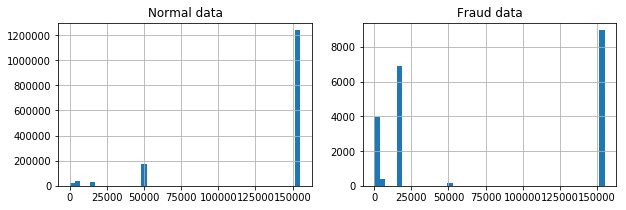

mchno_cano_nunique


<Figure size 432x288 with 0 Axes>

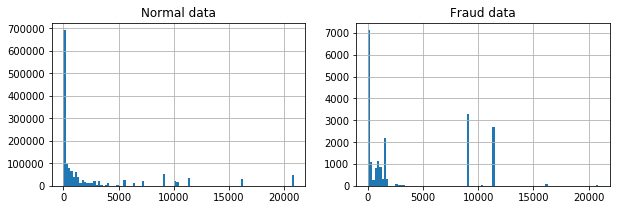

acqic_cano_nunique


<Figure size 432x288 with 0 Axes>

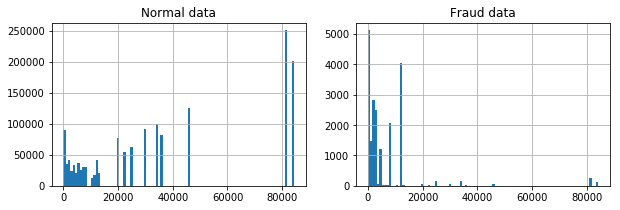

mcc_cano_nunique


<Figure size 432x288 with 0 Axes>

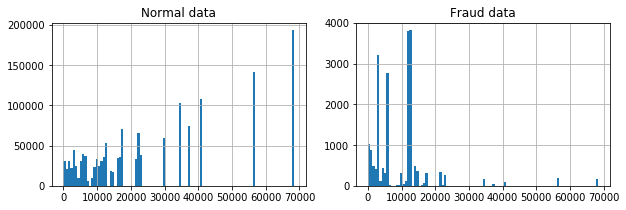

stocn_cano_nunique


<Figure size 432x288 with 0 Axes>

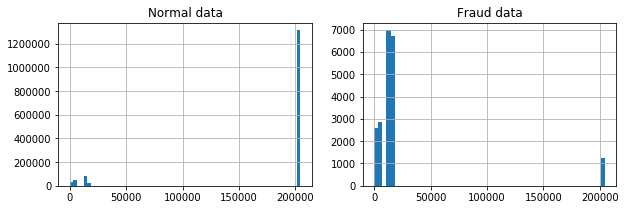

scity_cano_nunique


<Figure size 432x288 with 0 Axes>

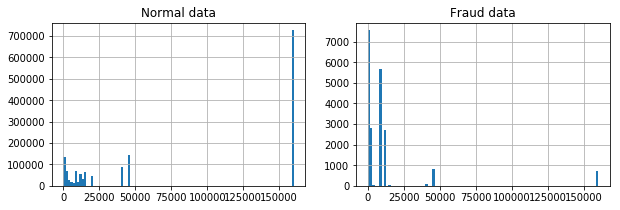

csmcu_cano_nunique


<Figure size 432x288 with 0 Axes>

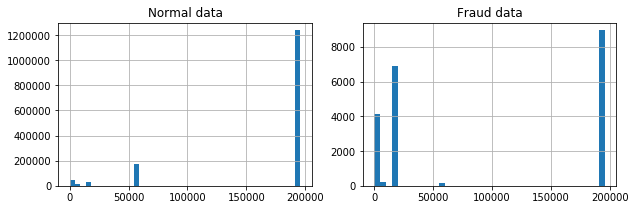

bacno_stocn_nunique


<Figure size 432x288 with 0 Axes>

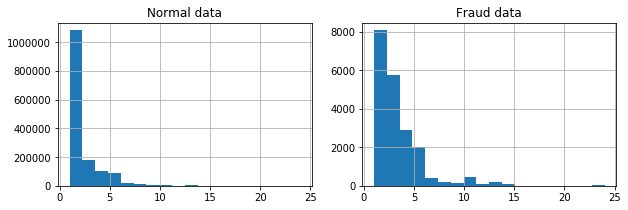

stocn_value_counts


<Figure size 432x288 with 0 Axes>

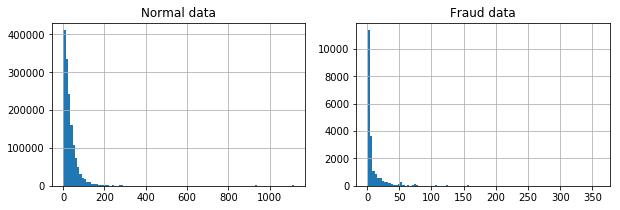

bacno_csmcu_nunique


<Figure size 432x288 with 0 Axes>

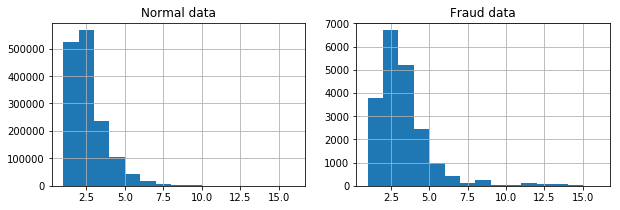

csmcu_value_counts


<Figure size 432x288 with 0 Axes>

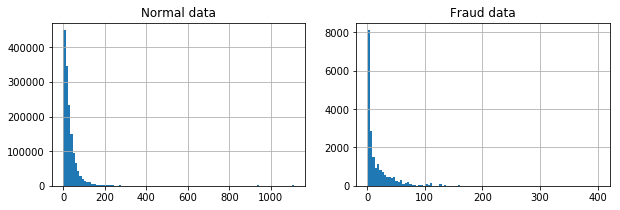

cano_only_consecutive_stscd2


<Figure size 432x288 with 0 Axes>

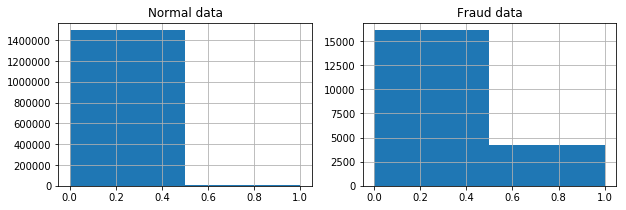

bacno_consecutive_and_only_ecfg


<Figure size 432x288 with 0 Axes>

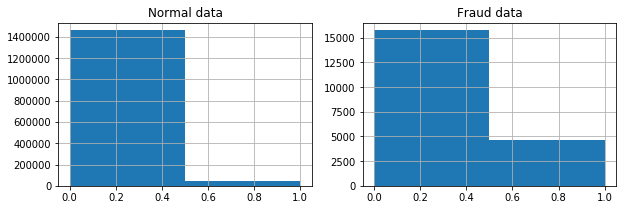

cano_lastday_use


<Figure size 432x288 with 0 Axes>

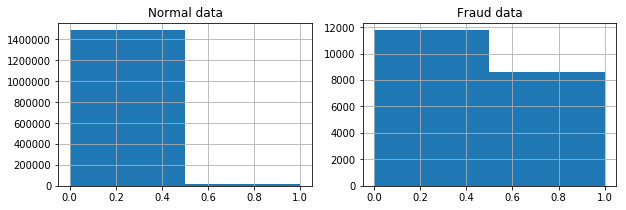

cano_lastday_use_twokind


<Figure size 432x288 with 0 Axes>

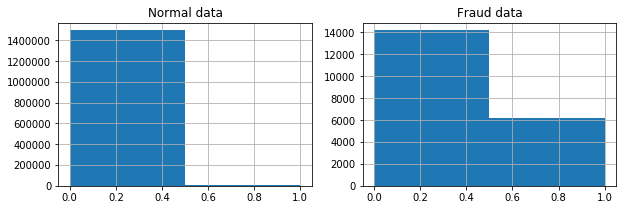

cano_lastlocdt


<Figure size 432x288 with 0 Axes>

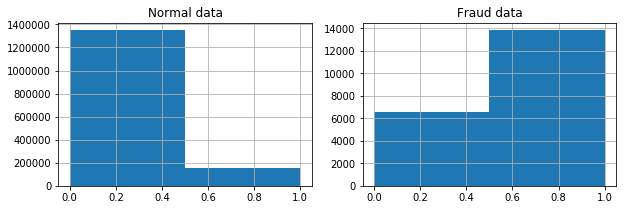

bacno_lastlocdt


<Figure size 432x288 with 0 Axes>

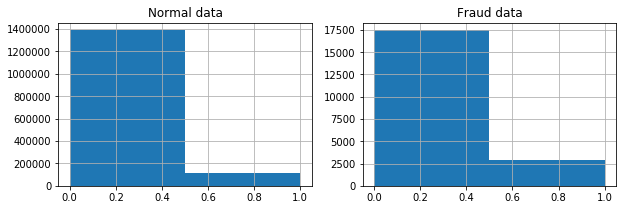

cano_lastlocdt2


<Figure size 432x288 with 0 Axes>

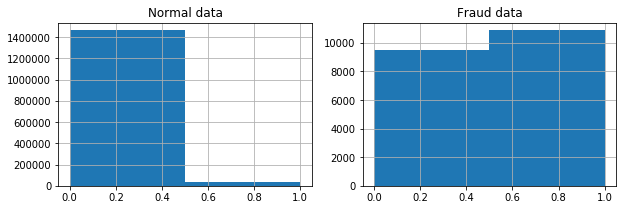

bacno_stscd_equal2


<Figure size 432x288 with 0 Axes>

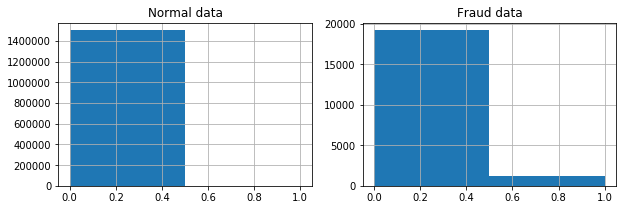

bacno_ecfg_equal1


<Figure size 432x288 with 0 Axes>

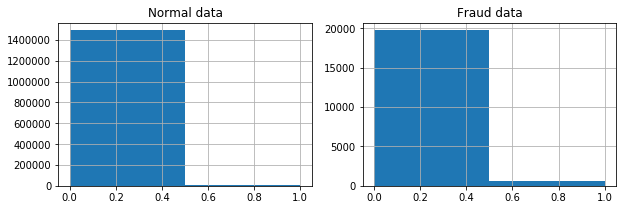

In [7]:
normal_data = all_data[all_data['fraud_ind']==0]
fraud_data = all_data[all_data['fraud_ind']==1]

for c in normal_data.columns:
    print(c)
    plt.clf()
    fig, axs = plt.subplots(1,2,figsize=(10,3))

    bins = normal_data[c].nunique() if normal_data[c].nunique()<100 else 100
    normal_data[c].hist(bins=bins,ax=axs[0])
    axs[0].set_title('Normal data')
    bins = fraud_data[c].nunique() if fraud_data[c].nunique()<100 else 100
    fraud_data[c].hist(bins=bins,ax=axs[1])
    axs[1].set_title('Fraud data')
    plt.show()


### 檢查在test data中,新出現的類別有多少
bacno, mchno, acqic, mcc, stocn, scity, csmcu 

In [8]:
def find_new_category(x,target_name):
    x_train = x[x['locdt']<=90][target_name].unique()
    x_test = x[x['locdt']>90][target_name].unique()
    
    print(target_name)
    print('{} categories in Training data:'.format(x_train.shape[0]))
    print('{} categories in Testing data:'.format(x_test.shape[0]))

    x_new_test=[]
    for b in x_test:
        if b not in x_train:
            x_new_test.append(b)

    print('{} new categories'.format(len(x_new_test)))    

In [9]:
## 幾乎所有在test data的都是新用戶 乾
## 所以重點特徵工程不能使用用戶過去的fraud記錄
# find_new_category(all_data,'bacno')

## 幾乎都太多只出現在test data上的新類別,這樣得轉換可以用來訓練(TODO)

# find_new_category(all_data,'mchno')
# find_new_category(all_data,'acqic')
# find_new_category(all_data,'mcc')
# find_new_category(all_data,'stocn')
# find_new_category(all_data,'scity')
# find_new_category(all_data,'csmcu')


## 觀察large category的feature是否有很多種bacno的fraud

In [10]:
# mchno_bacno_count = all_data.groupby('mchno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
# acqic_bacno_count = all_data.groupby('acqic').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
# mcc_bacno_count = all_data.groupby('mcc').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())

# print(mchno_bacno_count.sum())
# print(mchno_bacno_count[mchno_bacno_count>1].sort_values())

# print(acqic_bacno_count.sum())
# print(acqic_bacno_count[acqic_bacno_count>1].sort_values())

# print(mcc_bacno_count.sum())
# print(mcc_bacno_count[mcc_bacno_count>1].sort_values())

## 以每個bacno來看fraud情況
* 找出使用者被盜刷卡時，和一般的交易差在哪裡


In [11]:
bacno_fraud_count = all_data.groupby('bacno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].shape[0])

In [12]:
# print('All fraud instance',all_data.fraud_ind.sum(skipna=True))
# print('{} different bacno'.format(bacno_fraud_count[bacno_fraud_count>0].shape[0]))

# bacno_fraud_count[(bacno_fraud_count<10)&(bacno_fraud_count>0)].hist(bins=9)
# plt.show()
# plt.clf()
# bacno_fraud_count[(bacno_fraud_count>0)].hist(bins=100)

## 幾乎都只被騙過一兩次

In [13]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']
list3=['locdt','conam','cano','stocn','scity','flbmk','csmcu','ecfg','fraud_ind']
list4=['locdt','cano','mcc','etymd','stocn','scity','csmcu','fraud_ind']
# 
# ,'ecfg','etymd'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count==1)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>300:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    if all_data[all_data['bacno']==b]['ecfg'].sum()>=0:
        print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))
        
#     print(all_data[all_data['bacno']==b][list4].sort_values(by=['locdt']))


2 1.0
     locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
11       1   541.07   96923     0      0    102   77960        0.0
12       1   151.14   96923     0      0    102   30194        0.0
13       1   683.25   96923     0      0    102   87352        0.0
14       2   177.04   96923     0      0    102   30194        0.0
15       2   435.32   96923     0      0    102   77960        0.0
16       2   365.63   96923     0      0    102   77960        0.0
17       2   969.14   96923     0      0    102   87352        0.0
21       5   743.53  101555     0      0    102   93829        0.0
20       5  2291.16  101555     1      0    102   53657        0.0
18       5   499.21   96923     0      0    102   77960        0.0
19       5   288.05   96923     0      0    102   30194        0.0
22       6   229.88   96923     0      0    102   89739        0.0
23       7   170.00   96923     0      0    102   77960        0.0
24       7   229.88   96923     0      0    102   30194

      locdt   conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
1301      7    0.00  116505     0      0     46   54828        1.0
1302     35  927.21  116506     0      0    102   36337        0.0
1303     35    0.00  116506     0      0    102   59690        0.0
1304     36  776.57  116506     1      0    102   82174        0.0
1305     36  618.99  116506     0      0    102   78349        0.0
1306     37  566.17  116506     1      0    102   82174        0.0
1307     40    0.00  116506     0      0    102       0        0.0
1308     40  513.80  116506     0      0    102   59369        0.0
1309     44  884.33  116506     0      0    102   17884        0.0
1310     45  784.95  116506     1      0    102   19979        0.0
1311     45  317.01  116506     1      0    102   34332        0.0
1312     45  317.01  116506     1      0    102   34332        0.0
1313     46  588.75  116506     0      0    102    1080        0.0
1314     48  928.90  116506     0      0    102   17884       

      locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
5234      4     1.38  146866     0      0    102   38390        0.0
5235     11   724.05  146866     1      0    102   34176        0.0
5236     11  1680.34  146866     1      0    102   34239        0.0
5237     12   827.05  146866     1      0    102   38774        0.0
5238     15   652.03  146866     0      0    102   74331        0.0
5239     22    96.34  146866     1      2     27  102122        1.0
5240     28   570.66  146866     1      0    102   90091        0.0
5241     52   937.26  146866     1      0    102   80245        0.0

562 1.0
      locdt    conam   cano  ecfg  stscd  stocn   mchno  fraud_ind
5762      1   766.30  55483     1      0    102   20435        0.0
5763      2   439.36  55483     0      0    102   13632        0.0
5764      2   313.34  55482     0      0    102   13632        0.0
5765      2   373.76  55482     0      0    102    6487        0.0
5766      2   574.36  55485     1      0    

      locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
8958      5   420.41  54721     1      0    102  79200        0.0
8959      6   990.35  54721     0      0    102  70304        0.0
8960      6   366.38  54721     0      0    102  70304        0.0
8961      6   555.43  54721     0      0    102  70304        0.0
8962      7   465.62  54720     0      0    102      0        0.0
8963      7   639.86  54721     0      0    102  96716        0.0
8964      9  1406.20  54722     1      0     52  58066        0.0
8965     11   622.19  54721     0      0    102  18348        0.0
8966     11   638.95  54721     1      0    102  90166        0.0
8967     15  1194.20  54722     1      0     52  67113        0.0
8968     15   598.45  54721     1      0    102  80153        0.0
8969     16   406.59  54721     1      0    102  80204        0.0
8970     16   582.71  54721     0      0    102  20192        0.0
8972     18   512.91  54721     1      0    102  79200        0.0
8971     1

       locdt    conam   cano  ecfg  stscd  stocn   mchno  fraud_ind
13325     12     0.00  12224     0      0    104  102979        0.0
13326     23   598.80  12224     1      0    102   20023        0.0
13327     43   772.62  12224     1      0    102   84286        0.0
13328     46  1323.49  12224     1      0     20   44816        1.0
13329     57   981.75  12225     1      0    102   20437        0.0

1337 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
13349     23   446.15  161453     0      0    102  13631        0.0
13350     32  1208.10  161453     0      0    102  60275        0.0
13351     32  1638.28  161453     0      0    102  60275        0.0
13352     32   799.24  161453     0      0    102  60275        0.0
13353     68     0.00  161453     0      0    102  20292        0.0
13354     68     0.00  161453     0      0    102  20292        0.0
13355     68     0.00  161453     0      0    102  20292        0.0
13356     69     0.00  161453     0   

1878 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
18817      1   999.86  197097     0      0    102  51664        0.0
18818      2   961.40  197097     1      0    102  90005        0.0
18819      9   864.21  197097     0      0    102  15257        0.0
18820     12   599.14  197097     1      0    102  77061        0.0
18821     12   392.72  197097     1      0    102  77061        0.0
18822     15   451.14  197097     1      0    102  77061        0.0
18823     19   588.75  197097     0      0    102  78392        0.0
18824     32  1264.53  197097     0      0    102   3378        0.0
18825     34   887.30  197097     0      0    102  51664        0.0
18826     38   674.71  197097     1      0     20  36024        1.0
18827     44   683.25  197097     1      0    102  20118        0.0
18828     48   893.18  197097     0      0    102   8375        0.0
18829     60  1632.22  197097     0      0    102  49034        0.0
18830     71   578.02  197098     0    

       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
23087      7   976.75  78610     0      0    102  16610        0.0
23088     11   828.85  78610     0      0    102  91157        0.0
23089     11  1191.56  78610     0      0    102  53140        0.0
23090     13  1292.08  78610     0      0    102  39562        0.0
23091     16   884.33  78610     0      0    102  52304        0.0
23092     16  1053.99  78610     0      0    102  13021        0.0
23093     16   802.73  78610     0      0    102  16614        0.0
23094     23     0.00  78610     1      0     93  20984        0.0
23095     23  1145.76  78610     1      2      6  58820        1.0
23096     56   884.33  78611     0      0    102  90924        0.0
23097     58  1118.29  78611     0      0    102  52728        0.0
23098     80  1182.34  78611     0      0    102  39554        0.0
23099     89   612.83  78611     0      0    102  38255        0.0
23100     89   228.54  78611     0      0    102  78017       

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
25899      4   732.29  113877     0      0    102  78250        0.0
25900     33     0.00  113878     1      0     75  67588        0.0
25901     33   572.92  113878     1      0     75  56028        0.0
25902     33   623.35  113878     1      0     75  67588        0.0
25903     33   497.00  113878     1      0     75  67588        0.0
25904     34   853.68  113878     1      0     75  67588        0.0
25905     34   600.14  113878     1      0     75  56018        1.0
25906     34   770.11  113877     0      0    102  78250        0.0
25907     34   462.74  113878     1      2     75  67588        0.0
25908     37   465.62  113877     0      0    102      0        0.0
25909     64   770.11  113877     0      0    102  78250        0.0
25910     74   513.80  113877     0      0    102  59333        0.0
25911     78  1209.16  113879     0      0    102  48821        0.0
25912     79  1984.42  113879     0      0    10

3012 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
29323     20   794.93  190752     0      0    102  18419        0.0
29324     27   103.22  190752     1      2    104  68107        1.0
29325     28  1198.52  190751     0      0    102   1172        0.0
29326     42     1.38  190753     1      0    102  79246        0.0
29327     42   880.07  190753     1      0    102  79200        0.0
29328     47   956.15  190751     0      0    102  36964        0.0
29329     72   522.58  190753     1      0    102  52139        0.0
29330     72   547.53  190751     1      0    102  31442        0.0
29331     86   764.38  190751     0      0    102   3123        0.0

3014 1.0
       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
29333      6  220.35  91001     0      0    102   3221        0.0
29334     20    0.00  91001     0      0     46  54828        0.0
29335     32  633.15  91001     1      0    102  92863        0.0
29336     34  232.52  91001     0    

       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
34126      6   467.18  61702     1      0    102  90005        0.0
34127      8   490.68  61702     0      0    102  75600        0.0
34128      8   555.43  61702     0      0    102  75600        0.0
34129     14   751.13  61702     0      0    102  29897        0.0
34130     24   454.96  61702     0      0    102  28503        0.0
34131     24   438.21  61702     0      0    102  24135        0.0
34132     26   782.92  61702     0      0    102  32071        0.0
34133     27  1334.73  61701     1      0    104  59181        1.0
34134     31   384.46  61702     0      0    102  14351        0.0
34135     33   776.78  61702     0      0    102  38989        0.0
34136     41   732.99  61702     0      0    102  75600        0.0
34137     48   467.18  61702     1      0    102  90005        0.0

3601 1.0
         locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
34203        1   465.62  108905     0      0    1

4228 1.0
       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
39861      2   513.80  89343     0      0    102  59369        0.0
39862     12   217.54  89343     0      0    102  79111        0.0
39863     31   513.80  89343     0      0    102  59333        0.0
39864     41   796.90  89343     0      0    102  92463        0.0
39865     78  1168.10  89343     1      2      6  67293        1.0

4562 1.0
         locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
42774        5     0.00  65989     1      0     75  67619        0.0
42775        6  1069.77  65989     1      0      6  55875        0.0
42776        7   677.06  65989     1      0    102  78537        0.0
42777       16   896.70  65989     0      0    102  28894        0.0
42778       18  1017.48  65989     0      0    102  48269        0.0
42779       19   465.62  65989     0      0    102      0        0.0
42780       20   696.35  65989     1      0    102  78537        0.0
42781       22   638.35  65

5645 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
51864     19  1017.37  107687     1      0    102  78537        0.0
51865     22   663.50  107687     0      0    102  33473        0.0
51866     25   652.03  107687     0      0    102  62698        0.0
51867     56   652.03  107687     0      0    102  62698        0.0
51868     74     0.00  107687     0      0     38  54238        0.0
51869     74   949.14  107687     1      0    104  55807        1.0
51870     79   513.80  107688     0      0    102  59333        0.0

5657 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
51956      2   983.61  156429     0      0    102  19499        0.0
51957      9     0.00  156429     0      0     44  33794        0.0
51958     10   682.99  156429     1      0    102  34176        0.0
51959     12   547.53  156429     0      0    102  24310        0.0
51960     16  1593.74  156429     1      0     38  75079        1.0
51961     22   672.97  156430

       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
55616      2  168.20  39337     1      0     38  54238        1.0
55617     54  166.38  39338     0      0    102  78202        0.0
55618     74  446.71  39338     0      0    102  32791        0.0

6042 1.0
       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
55824      1   882.92  125739     0      0    102   51658        0.0
55825      7   916.46  125739     1      0    102   38838        0.0
55826      7   796.90  125738     1      0     38   33774        0.0
55827      7  1017.48  125738     1      2     38   33774        1.0
55828      7  1017.48  125738     1      0     27   72070        0.0
55829      7  1017.48  125738     1      2     38   33774        0.0
55830      7  1017.48  125738     1      2     27   72070        0.0
55831      7   407.87  125738     1      2     27   67681        0.0
55832      8   513.80  125739     0      0    102     544        0.0
55833     10   806.00  125739     0 

       locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
59681      1  490.19  196680     0      0    102  45705        0.0
59682      4  695.83  196680     1      0    102  82174        0.0
59683      8  827.05  196680     1      0    102  53461        0.0
59684     10  182.16  196680     0      0    102  91514        0.0
59685     13  513.80  196680     0      0    102  59333        0.0
59686     16  601.51  196680     0      0    102  78021        0.0
59687     17  588.75  196680     0      0    102  91515        0.0
59688     26  610.86  196680     1      0    102  34290        0.0
59689     31  342.90  196680     0      0    102  77137        0.0
59690     33  465.62  196680     0      0    102      0        0.0
59691     33  175.31  196680     0      0    102  91514        0.0
59692     34  556.60  196680     0      0    102  45705        0.0
59693     41  713.91  196680     1      0    102   1634        0.0
59694     45  595.71  196680     1      0    102  19969       

7218 1.0
       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
66894     11   239.00  139782     0      0    102   89759        0.0
66895     12     0.00  139782     0      0     46   54828        0.0
66896     17   103.48  139782     1      0     46   54828        0.0
66897     19   239.00  139782     0      0    102   89759        0.0
66898     26   239.00  139782     0      0    102   89759        0.0
66899     32   560.08  139782     0      0    102   92771        0.0
66900     33   465.62  139782     0      0    102       0        0.0
66901     36   227.20  139782     0      0    102   89759        0.0
66902     39   513.80  139782     0      0    102   59333        0.0
66903     42     0.00  139782     0      0    102   59690        0.0
66904     42     0.00  139782     0      0    104  103106        0.0
66905     43     1.38  139782     0      0    102   38390        0.0
66906     43   225.84  139782     0      0    102   89759        0.0
66907     44   754.87  13

       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
73856      7   874.00  185731     0      0    102    6476        0.0
73857      7   865.04  185731     0      0    102    6476        0.0
73858      8  1119.20  185731     0      0    102   87406        0.0
73859     27  2059.51  185731     0      0    102     908        0.0
73860     53  1468.31  185731     0      0    102   78638        0.0
73861     53  1382.67  185731     0      0      5   51214        1.0
73862     61  1298.06  185731     0      0     27   53408        0.0
73863     62  1414.82  185731     0      0     17   53398        0.0
73864     76  1117.74  185731     0      0    102    1787        0.0
73865     89  1366.81  185731     0      0      5  103033        0.0
73866     89  1112.36  185731     0      0      5   51340        0.0

7969 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
74372      4   453.33  176921     0      0    102  78000        0.0
74373     13   823.95  176

       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
81266      1   465.62    5959     0      0    102       0        0.0
81267      3   465.62    5959     0      0    102       0        0.0
81268      3   985.09    5960     0      0    102   77989        0.0
81269      6   475.90    5960     0      0    102   22894        0.0
81270      7   465.62    5959     0      0    102       0        0.0
81271      8   723.33    5960     0      0    102   92768        0.0
81272      8   719.35    5959     1      0     44   33794        1.0
81273      9   465.62    5959     0      0    102       0        0.0
81274      9   716.59    5960     0      0    102   97174        0.0
81275     12   465.62    5959     0      0    102       0        0.0
81276     12   741.26    5960     0      0    102   77989        0.0
81277     12  1389.49    5960     1      0    102   75824        0.0
81278     14   702.72    5960     0      0    102   92768        0.0
81279     14   476.56  209227     

       locdt    conam  cano  ecfg  stscd  stocn  mchno  fraud_ind
86394      4   588.39  3883     0      0    102  38254        0.0
86395     10   407.87  3883     1      0    102  84528        0.0
86396     17   717.80  3884     0      0    102  78499        0.0
86397     33   590.85  3883     0      0    102  38254        0.0
86398     41   407.87  3883     1      0    102  84528        0.0
86399     46   369.36  3884     0      0    102  78499        0.0
86400     51     0.00  3883     1      0     38  54238        1.0
86401     67  1195.98  3884     0      0    102  78142        0.0
86402     73   572.89  3884     0      0    102  78190        0.0

9229 1.0
       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
86412     10  1219.49  118010     0      0    102   78194        0.0
86413     19     0.00  118009     0      0     46   54828        0.0
86414     22   317.01  118009     1      0     46   54828        0.0
86415     22   103.48  118009     1      0     46   54

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
92164      3   522.58  156208     1      0    102  78537        0.0
92165      4   465.62  156208     0      0    102      0        0.0
92166      8   551.51  156208     1      0    102  78537        0.0
92167      9   797.37  156209     1      0     25  43811        1.0
92168      9   651.74  156208     0      0    102  89761        0.0
92169      9   485.83  156208     0      0    102   2321        0.0
92170      9   614.14  156208     0      0    102  79045        0.0
92171     14   628.18  156208     0      0    102  89761        0.0
92172     14   625.35  156208     0      0    102  28649        0.0
92173     15   410.43  156208     1      0    102  34176        0.0
92174     18   599.14  156208     0      0    102  89761        0.0
92175     20   465.62  156208     0      0    102      0        0.0
92176     21   623.14  156208     0      0    102  89761        0.0
92177     24  1004.13  156208     0      0    10

       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
97643     19     0.08  89843     0      2     52  62792        1.0
97644     24   437.63  89844     0      0    102  19499        0.0
97645     51   845.63  89844     0      0    102  19499        0.0
97646     64  1428.96  89844     1      0      1  43754        0.0
97647     66   465.62  89844     0      0    102      0        0.0
97648     75  1628.52  89844     0      0    102  31866        0.0
97649     82   465.62  89844     0      0    102      0        0.0
97650     89   465.62  89844     0      0    102      0        0.0

10604 1.0
       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
98088      7   863.22  41538     1      0    102  34176        0.0
98089     10   833.88  41538     1      0    102  34381        0.0
98090     14     0.00  41538     1      0     38  54238        0.0
98091     15   655.51  41538     1      0    102  34381        0.0
98092     15  1016.34  41538     1      0     38  5

        locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
101472      8  1216.09  209604     0      0    102  86799        0.0
101473      9  1178.91  209604     0      0    102  95793        0.0
101474      9   979.26  209604     0      0    102  95951        0.0
101475     10   553.87  209604     0      0    102  60305        0.0
101476     24   229.88  209604     0      0    102  78068        0.0
101477     44   625.35  209604     0      0    102  78068        0.0
101478     45   649.69  209604     0      0    102  77999        0.0
101479     48   513.80  209604     0      0    102  59333        0.0
101480     48   865.04  209604     0      0    102  34949        0.0
101481     48   513.36  209604     1      0    102  75824        0.0
101482     52   513.80  209604     0      0    102  59333        0.0
101483     52   522.58  209604     0      0    102  78068        0.0
101484     70   672.14  209604     0      0    102  60305        0.0
101485     70     0.00  209604    

        locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
106007     11   636.82  184651     0      0    102  91474        0.0
106008     19   452.24  184651     0      0    102  16617        0.0
106009     19   520.41  184651     0      0    102  16607        0.0
106010     35   649.69  184651     0      0    102  53978        0.0
106011     38   911.65  184651     0      0    102  44693        0.0
106012     41   648.81  184651     0      0    102  93900        0.0
106013     41  1558.27  184651     0      0    102  93491        0.0
106014     43   730.66  184651     0      0    102  16605        0.0
106015     44  1063.05  184651     0      0    102  17683        0.0
106016     45   721.18  184651     0      0    102  16609        0.0
106017     45   930.35  184651     1      0     44  33794        1.0
106018     57  1554.45  184652     1      0    102  81727        0.0
106019     63   812.26  184652     1      0    102  82174        0.0
106020     68   734.84  184652    

        locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
112595      4  839.54  100312     0      0    102  48784        0.0
112596     32  110.79  178211     0      2      1  59702        1.0

12077 1.0
         locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
112655       2   962.96  181152     0      0    102  87926        0.0
112656       2  1428.23  181152     0      0    102  34439        0.0
112657      10   168.20  181152     1      0     46  54828        0.0
112658      18  1664.78  181152     0      0    102  51588        0.0
112659      18   201.39  181152     1      0     46  54828        0.0
112660      23  1144.36  181152     0      0    102  34407        0.0
112661      29     0.00  181152     1      0     38  54238        0.0
112662      30   201.39  181152     0      0    102  37186        0.0
112663      30   292.12  181152     0      0    102  37186        0.0
112664      44   945.07  181152     1      0    104  55807        1.0
112665      56 

        locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
117972     21   841.11  175405     0      0    102  77873        0.0
117973     30     0.00  175405     1      0     38  54238        0.0
117974     30   942.98  175405     1      0    104  55807        1.0
117975     54  1018.51  175406     0      0    102  89834        0.0
117976     69   700.69  175406     0      0    102  35730        0.0
117977     76  1104.39  175406     0      0    102  16695        0.0
117978     83   438.78  175406     0      0    102  30833        0.0

12779 1.0
        locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
119030      3    89.79  164987     1      0    102   20126        0.0
119031      3   103.48  164987     1      0    102   20126        0.0
119032      5   116.10  164987     1      0    102   20129        0.0
119033      5   166.38  164987     1      0    102   20126        0.0
119034      8    74.77  164987     1      0    102   20126        0.0
119035     12    

In [14]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','cano','cano_ratio_ecfg','bacno_ratio_ecfg','fraud_ind']
# 
# ,'ecfg'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count==1)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>100:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    print(all_data[all_data['bacno']==b][list1].sort_values(by=['locdt']))


2 1.0
     locdt    cano  etymd   mchno  acqic  mcc  stocn    conam  fraud_ind
11       1   96923      4   77960   6032  251    102   541.07        0.0
12       1   96923      4   30194   6035  257    102   151.14        0.0
13       1   96923      4   87352   6189  275    102   683.25        0.0
14       2   96923      4   30194   6035  257    102   177.04        0.0
15       2   96923      4   77960   6032  251    102   435.32        0.0
16       2   96923      4   77960   6032  251    102   365.63        0.0
17       2   96923      4   87352   6189  275    102   969.14        0.0
21       5  101555      4   93829   6189  263    102   743.53        0.0
20       5  101555      2   53657   6430  201    102  2291.16        0.0
18       5   96923      4   77960   6032  251    102   499.21        0.0
19       5   96923      4   30194   6035  257    102   288.05        0.0
22       6   96923      4   89739   6189  263    102   229.88        0.0
23       7   96923      4   77960   6032  25

      locdt    cano  etymd  mchno  acqic  mcc  stocn    conam  fraud_ind
2996      1   64155      8  38207   6322  209    102   922.66        0.0
2997      2   64156      4  46322   6716  251    102   609.21        0.0
2998      2   64156      5  23157   6678  305    102  1070.52        0.0
2999      3   64156      5   3133   6581  250    102   456.05        0.0
3000      3   64156      0  59333   6881  457    102   513.80        0.0
3001      3   64156      5  78151   6032  247    102   788.17        0.0
3002     17  185732      8  54238   3348  380     38   696.35        1.0
3003     30   64156      4  46322   6716  251    102   769.90        0.0
3004     32   64156      0  86584   6881  457    102   513.80        0.0
3005     35   64156      4  37889   6716  357    102   513.80        0.0
3006     40   64156      0  68956   6881  457    102   513.80        0.0
3007     46   64156      2  92742   6189  264    102   648.22        0.0
3008     57   64156      0  74732   6881  457    10

      locdt    cano  etymd  mchno  acqic  mcc  stocn    conam  fraud_ind
9172     13  108967      8  54828   3348  289     46   103.48        0.0
9173     20  108967      8  43614   5753  329     52  1385.16        1.0
9174     28  108968      5  12673   6767  277    102   625.04        0.0
9175     39  108968      5  35693   6716  292    102   639.86        0.0
9176     43  108968      4  38956   6716  270    102   655.51        0.0
9177     82  108968      5   6478   6767  247    102   513.36        0.0

1004 1.0
       locdt    cano  etymd  mchno  acqic  mcc  stocn    conam  fraud_ind
10233      7  158485      0  58624   6881  457    102   513.80        0.0
10234      8  158485      5  17911   6231  349    102   851.64        0.0
10235      8  158485      5  76326   6655  349    102   332.86        0.0
10236     10  158485      5  51514   6413  349    102  1120.56        0.0
10237     18  158485      5  79110   6032  247    102   469.77        0.0
10238     18  158485      5  79110 

       locdt    cano  etymd   mchno  acqic  mcc  stocn    conam  fraud_ind
17353     11  195426      0     611     60  453    102   513.80        0.0
17354     20  195426      8     929   6777  247    102   480.41        0.0
17355     26  195426      8   84543   6769  329    102   585.21        0.0
17356     27  195426      8     929   6777  247    102   692.47        0.0
17357     28  195426      0     544   5136  453    102   513.80        0.0
17358     28  195426      2   84543   6769  329    102   585.21        0.0
17359     34  195426      0     544   5136  453    102   513.80        0.0
17360     46  195426      0     611     60  453    102   513.80        0.0
17361     57  195426      0     544   5136  453    102   513.80        0.0
17364     61  195426      8   55807   3221  288    104   948.38        0.0
17362     61  195426      8   54238   3348  380     38     0.00        1.0
17363     61  195426      8   55807   3221  288    104   948.38        0.0
17365     71  195427     

       locdt    cano  etymd  mchno  acqic  mcc  stocn    conam  fraud_ind
24587      5  106249      0  59333   6881  457    102   513.80        0.0
24588      8  106249      0  59333   6881  457    102   513.80        0.0
24589     10  106249      0  59369   6881  457    102   513.80        0.0
24590     11  106249      4  27946   6677  207    102  1130.35        0.0
24591     13  106249      0  59333   6881  457    102   513.80        0.0
24592     16  106249      0  59369   6881  457    102   513.80        0.0
24593     18  106249      0  59369   6881  457    102   513.80        0.0
24594     19  106249      2  34217   6716  248    102   791.17        0.0
24595     21  106249      0  59369   6881  457    102   513.80        0.0
24596     22  106249      4  14473   6231  332    102  1297.50        0.0
24597     27  106249      0  59333   6881  457    102   513.80        0.0
24598     30  106249      0  59333   6881  457    102   513.80        0.0
24599     32  106249      0  59369   6

       locdt   cano  etymd  mchno  acqic  mcc  stocn   conam  fraud_ind
29333      6  91001      9   3221   6581  264    102  220.35        0.0
29334     20  91001      2  54828   6215  289     46    0.00        0.0
29335     32  91001      2  92863   6189  397    102  633.15        0.0
29336     34  91001      9   3221   6581  264    102  232.52        0.0
29337     35  91001      5  46435   6716  257    102  837.60        0.0
29338     36  91001      2  54828   6215  289     46  103.48        1.0

3113 1.0
         locdt   cano  etymd  mchno  acqic  mcc  stocn    conam  fraud_ind
30167        1  76064      9  17747   6767  251    102   377.38        0.0
30168        1  76064      9  17747   6767  251    102   160.81        0.0
30169        2  76065      4   4260   6777  292    102   734.15        0.0
30170        5  76065      8  90005   5975  191    102   609.21        0.0
30171       11  76065      2  38254   6322  209    102   557.76        0.0
30172       13  76065      4  17747 

曾經在該國被盜刷的紀錄
曾經在該mchno被盜刷的紀錄
曾經在該mchno被盜刷
最後一筆是不是盜刷
